# DAT 205 Project - Transform data
## By Dennis Hung
## Version 1
## Code DRAFT 2021-03-27

## Code Strucuture
### Section 0: Function definitions
### Section 1: Import libraries
### Section 2: Configuration of variables

### Section 3: Load the dataset from file and initial analysis
#### Section 3.1: Load the dataset from file
#### Section 3.2: Initial Analysis

### Section 4: Transforming/cleansing the data 
#### Section 4.1: Enhance the data
#### Prepare data enhancement attributes in dataframe (df_TF) and create UID
#### Create new TeamGameStats dataframe to aggregate data by UID_STG
### Section 4.2:  NBA Advanced Stat - PIE (Player Impact Efficiency)
### Section 4.3:  NBA Advanced Stat - PER (Player Efficiency Rating)
### Section 4.4 Filter data by Team (if specified)
### Section 4.5: Remove (Stage 1) from dataframe the unwanted numerical/categorical features
### Section 4.6: Transform categorical feature (WL) using value replace
### Section 4.7: Transform categorical features using LabelEncoder
### Using OneHotEncoding (Not Working)
### Section 4.8: Define TARGET variable and separate into dataframes by season type

## Section 5: Analysis - Heat Maps / Correlation Matrices
### Section 5.1: Plot Heat Maps for Pre Season, Regular Season, and Playoffs
### Section 5.2: Remove additional unwanted fields based on Heat Map / Correlation Matrix
### Section 5.3: Re-check Heat Map / Correlation Matrix

## Section 6: Modeling and Analysis
### Section 6.1: Prepare train and test data
### Section 6.2: Apply Logistic Regression on the split train/test dataset
### Section 6.3: Apply Decision Tree Classifier on the split train/test dataset
### Section 6.4: Apply Random Forest Classifier on the split train/test dataset

## Section 7: Cross Validation Scores

## Section 8: Summary Report

## End of Code




##  Reference

#### How to Get NBA Data Using the nba_api Python Module (Beginner). Retrieved from Plyaing Numbers: 

https://www.playingnumbers.com/2019/12/how-to-get-nba-data-using-the-nba_api-python-module-beginner/

#### Patel, S. (2020, August 19). swar / nba_api. Retrieved from GitHub: 

https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md

#### Issues

https://github.com/swar/nba_api/issues/124



# Note: 
#### This code relies on the CSV output from "DAT 205-Group01-NBA-HistPlayGameLogs.ipynb" as the dataset for this transformation.

# Section 0: Function definitions

hms_string(sec_elapsed)


In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60))/60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h,m,s)

# Null field analysis
def nullFieldAnalysis(df):
    df_missingDataInfo = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})
    #Printing the columns with over XX% of missing values (ie 60 = 60%) This is set to 0 for 0%
    null_threshold = 0 
    print("")
    print("")
    print("==== Null value analysis ====")
    return df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].sort_values(by=['Percent'])

# CalcThreshold_List
def CalcThreshold_List(totalRecords):
    CTL_10 = int(round(totalRecords*0.1,0))
    CTL_20 = int(round(totalRecords*0.2,0))
    CTL_30 = int(round(totalRecords*0.3,0))
    CTL_40 = int(round(totalRecords*0.4,0))
    CTL_50 = int(round(totalRecords*0.5,0))
    CTL_60 = int(round(totalRecords*0.6,0))
    CTL_70 = int(round(totalRecords*0.7,0))
    CTL_80 = int(round(totalRecords*0.8,0))
    CTL_90 = int(round(totalRecords*0.9,0))
    CTL_100 = int(round(totalRecords*1,0))

    CTL_05 = int(round(totalRecords*0.05,0))
    CTL_15 = int(round(totalRecords*0.15,0))
    CTL_25 = int(round(totalRecords*0.25,0))
    CTL_35 = int(round(totalRecords*0.35,0))
    CTL_45 = int(round(totalRecords*0.45,0))
    CTL_55 = int(round(totalRecords*0.55,0))
    CTL_65 = int(round(totalRecords*0.65,0))
    CTL_75 = int(round(totalRecords*0.75,0))
    CTL_85 = int(round(totalRecords*0.85,0))
    CTL_95 = int(round(totalRecords*0.95,0))

    Threshold_List = [1, CTL_05, CTL_10, CTL_15, CTL_20, CTL_25, CTL_30, CTL_35, CTL_40, CTL_45, 
                    CTL_50, CTL_55, CTL_60, CTL_65, CTL_70, CTL_75, CTL_80, CTL_85, 
                    CTL_90, CTL_95, CTL_100]
    return Threshold_List


# Section 1: Import libraries

In [2]:
# Initialized required packages
# Standard packages
import numpy as np
import pandas as pd
import scipy as sp
import csv
import time

# Graphing packages
import seaborn as sns

# import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines

# Data preparation
from sklearn.preprocessing import LabelEncoder

# Modeling packages
# import tensorflow as tf
# import sklearn as skl
from sklearn.model_selection import train_test_split

# Regression modeling
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# from sklearn.model_selection import cross_val_score

# Confusion matrix, Accuracy, sensitivity and specificity
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

# from sklearn.feature_selection import VarianceThreshold 
from sklearn.feature_selection import RFE 
# from sklearn.feature_selection import RFECV

# Clustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Following code is being deprecated
# from sklearn.datasets.samples_generator import make_blobs

# Initialize variables if there is any debugging required
# Insert following line and activate the debugging.
# # VALIDATION CODE 
# if debug_active == 'yes':
# 
# Use "display(df)"" if the result command is "df" to retain the same format



start_time = time.time()

# Section 2: Configuration of variables

Must manually set the following variables

gameTypeListed as one of the following: 'Pre Season', 'Regular Season', 'Playoffs'

seasonsListed for the game season in this format '2015-16'. Have at least 2 values

In [3]:

# General configuration
debug_active = 'yes'
loop_max = 100
# showNumRecs = 15
numFormat = '{:.4f}'
numFormat_Pct = "{:.0%}"

# Data Transformation 'yes' or other
dataEnhancement_active = 'yes'
# dataEnhancement_active = 'no'
    
# Section 3.1: Load the dataset from file
# pick who is running the code and comment out the others
# coder = 'bhavika'
# coder = 'cindy'
coder = 'dennis'

# Setup file name for csv or Excel (.xlsx)
if coder == 'bhavika':
    filename = 'D:/McMaster/DAT205/Capstone/Data/HistoricalGameLogs_2004-05_to_2019-20_ALL.csv'
elif coder == 'dennis':
    filename = './HistoricalGameLogs_2004-05_to_2019-20_ALL.csv'
    # filename = './DAT205_Output_Enhanced_df_TF 2004-2020.csv'
    # Test Data files
    # filename = './HistoricalGameLogs_2007-08_to_2008-09_ALL.csv'
    # filename = './DAT205_Output_Enhanced_df_TF 2007-09.csv'
    

# filename = filename + seasonStart + '_to_' + seasonEnd + '_' + gameType + '.csv'
# filename = filename + seasonStart + '_to_' + seasonEnd + '_ALL' + '.csv'


# Section 4.4 Filter data by Team (if specified)
# Filter the dataset by team or None
allTeamsList = ['CLE', 'LAC', 'NOH', 'WAS', 'ORL', 'NJN', 'PHX', 'DET', 'IND', \
       'CHA', 'DAL', 'ATL', 'NYK', 'CHI', 'BOS', 'MIN', 'PHI', 'HOU', \
       'POR', 'TOR', 'SAC', 'UTA', 'GSW', 'MIA', 'SEA', 'MEM', 'LAL', \
       'SAS', 'DEN', 'MIL', 'NOK', 'ZAK', 'CHN', 'PAN', 'RMA', 'MMT', \
       'MTA', 'MAL', 'LRO', 'EPT', 'OKC', 'LRY', 'BAR', 'MOS', 'OLP', \
       'PAR', 'LAB', 'MAC', 'MLN', 'BKN', 'FCB', 'RMD', 'MPS', 'EAM', \
       'ALB', 'FBU', 'NOP', 'UBB', 'FLA', 'BAU', 'FEN', 'SLA', 'SDS', \
       'BNE', 'MEL', 'SYD', 'GUA', 'PER', 'ADL', 'NZB', 'BJD', 'FRA']
# teamSelected = 'None'
teamSelected = 'TOR'

# Section 6: Modeling and Analysis
random_state_val = 42

# Section 6.1: Prepare train and test data
# Select a season 
gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
gameTypeListed_code = [0, 1, 2]
gameTypeToProcess = 1
test_size_val = 0.30

# Section 5: Analysis - Heat Maps / Correlation Matrices
plotSize = (20,15)




# # TEST CODE
# # Option 1: For all currently possible seasons
# # seasonsListed = ['1946-47', '1947-48', '1948-49', '1949-50'
# # , '1950-51', '1951-52', '1952-53', '1953-54', '1954-55', '1955-56', '1956-57', '1957-58', '1958-59', '1959-60'
# # , '1960-61', '1961-62', '1962-63', '1963-64', '1964-65', '1965-66', '1966-67', '1967-68', '1968-69', '1969-70'
# # , '1970-71', '1971-72', '1972-73', '1973-74', '1974-75', '1975-76', '1976-77', '1977-78', '1978-79', '1979-80'
# # , '1980-81', '1981-82', '1982-83', '1983-84', '1984-85', '1985-86', '1986-87', '1987-88', '1988-89', '1989-90'
# # , '1990-91', '1991-92', '1992-93', '1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99', '1999-00'
# # , '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'
# # , '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20'
# # , '2020-21']

# seasonsListed = ['2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'
# , '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# seasonStart = seasonsListed[0]
# seasonEnd = seasonsListed[-1]

# # Request info for each season in the list
# df_gamelogs_player = []
# countFirstYear = 0

# Section 3: Load the dataset from file and initial analysis

## Section 3.1: Load the dataset from file

In [4]:
# load the CSV or Excel file 
# Note the other option in Jupyter Notebook is to use the upload the csv files before running the code

# lst of column names which needs to be string
lst_str_cols = ['GAME_ID']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
# use dict on dtypes
df = pd.read_csv(filename, dtype=dict_dtypes)
# Excel file import
# df = pd.read_excel(filename)




# Remove duplicate index from import
unwanted_list = ['Unnamed: 0']

X_headers_list = df.columns.tolist()
for x in unwanted_list:
    X_headers_list.remove(x)

# Display current dataframe
df_Initial = df[X_headers_list]

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Initial)
    # Examine shape of dataframe
    display(df_Initial.shape)
    # Examine the type of attributes in the dataframe
    print("Shape of the dataset")
    df_Initial.info()
    # Describe the numerical data
    df_Initial.describe()
    


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
0,2004-05,2400,Drew Gooden,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,0,3,0,6,12,0,0,Regular Season
1,2004-05,2060,Marko Jaric,1610612746,LAC,Los Angeles Clippers,0020401225,2005-04-20T00:00:00,LAC @ NOH,W,...,0,0,0,1,0,14,11,0,0,Regular Season
2,2004-05,2544,LeBron James,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,1,1,0,27,9,1,1,Regular Season
3,2004-05,2561,David West,1610612740,NOH,New Orleans Hornets,0020401225,2005-04-20T00:00:00,NOH vs. LAC,L,...,0,1,1,5,0,11,7,0,0,Regular Season
4,2004-05,2413,Juan Dixon,1610612764,WAS,Washington Wizards,0020401222,2005-04-20T00:00:00,WAS @ NYK,L,...,0,0,0,2,0,13,0,0,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,204060,Joe Ingles,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,1,0,0,3,5,19,-14,0,0,Playoffs
465061,2019-20,1626144,Emmanuel Mudiay,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,0,0,0,0,1,1,1,0,0,Playoffs
465062,2019-20,203924,Jerami Grant,1610612743,DEN,Denver Nuggets,0041900161,2020-08-17T00:00:00,DEN vs. UTA,W,...,1,1,0,2,6,19,1,0,0,Playoffs
465063,2019-20,1626196,Josh Richardson,1610612755,PHI,Philadelphia 76ers,0041900121,2020-08-17T00:00:00,PHI @ BOS,L,...,0,0,2,2,2,18,-10,0,0,Playoffs


(465065, 35)

Shape of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465065 entries, 0 to 465064
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEASON_YEAR        465065 non-null  object 
 1   PLAYER_ID          465065 non-null  int64  
 2   PLAYER_NAME        464325 non-null  object 
 3   TEAM_ID            465065 non-null  int64  
 4   TEAM_ABBREVIATION  465065 non-null  object 
 5   TEAM_NAME          465065 non-null  object 
 6   GAME_ID            465065 non-null  object 
 7   GAME_DATE          465065 non-null  object 
 8   MATCHUP            465065 non-null  object 
 9   WL                 465016 non-null  object 
 10  MIN                465065 non-null  float64
 11  FGM                465065 non-null  int64  
 12  FGA                465065 non-null  int64  
 13  FG_PCT             465065 non-null  float64
 14  FG3M               465065 non-null  int64  
 15  FG3A               465065 non-

## Section 3.2: Initial Analysis

In [5]:
# Display the headers of columns that use descriptive or non-numerical values
categorical_Features = df_Initial.dtypes[df_Initial.dtypes == "object"].index.tolist()

# VALIDATION CODE 
if debug_active == 'yes':
    print("VALIDATION CODE")
    print(categorical_Features)

# Describe the categorical data
print("")
print("")
print("==== Description of the categorical features ====")
display(df_Initial[categorical_Features].describe())

# # Null field analysis
nullFieldAnalysis(df_Initial)
# # Null field analysis
# df_missingDataInfo = pd.DataFrame({'Count': df_Initial.isnull().sum(), 'Percent': 100*df_Initial.isnull().sum()/len(df)})

# #Printing the columns with over XX% of missing values (ie 60 = 60%) This is set to 0 for 0%
# null_threshold = 0 
# print("")
# print("")
# print("==== Null value analysis ====")
# df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].sort_values(by=['Percent'])

VALIDATION CODE
['SEASON_YEAR', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'Game_Type']


==== Description of the categorical features ====


,SEASON_YEAR,PLAYER_NAME,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,Game_Type
count,465065,464325,465065,465065,465065,465065,465065,465016,465065
unique,16,2389,72,78,22104,3563,2392,2,3
top,2015-16,LeBron James,SAS,San Antonio Spurs,0010500120,2018-10-05T00:00:00,LAL vs. DEN,L,Regular Season
freq,30809,1514,17937,17937,36,339,604,232520,399371




==== Null value analysis ====


,Count,Percent
WL,49,0.010536
PLAYER_NAME,740,0.159118


# 

# Section 4: Transforming/cleansing the data 

## Data cleansing of nulls (Not working)

## Correction to missing PreSeason games WL values only 

49 PreSeason records 

2007-08 
GAME_ID 0010700072 / 2007-10-19
BOS vs NJN   W 36 to L 33

2008-09 
GAME_ID 0010800035 / 2008-10-11
DEN vs PHX   W 77 to L 72
Note some player game data seems missing

## Corrected missing player name data

740 records (727 preseason and 13 regular season)

This is not important as the player names are excluded from the analysis



In [6]:
# # df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].loc[df_missingDataInfo[]]

# missingDataInfo_List = df_missingDataInfo.loc[df_missingDataInfo['Count']>0].index.tolist()
# # ['PLAYER_NAME', 'WL']

# numOfRows = len(df_missingDataInfo.index)

# for missingDataInfo_Value in missingDataInfo_List:
#     df_missingDataInfo[df_missingDataInfo[index] = missingDataInfo_Value]


# # Pull player data
# from nba_api.stats.static import players
# player_dict = players.get_players()


# # Use ternary operator or write function 
# # Names are case sensitive
# bron = [player for player in player_dict if player['full_name'] == 'LeBron James'][0]
# bron_id = bron['id']

# # find team Ids
# from nba_api.stats.static import teams 
# teams = teams.get_teams()
# GSW = [x for x in teams if x['full_name'] == 'Golden State Warriors'][0]
# GSW_id = GSW['id']

## Section 4.1: Enhance the data

In [7]:
# Setup variables for data transformation
df_TF = df_Initial
totalNumRec = df_TF.shape[0]

# Check df_TeamGameStats
# VALIDATION CODE 
if debug_active == 'yes':
    print(totalNumRec)
    display(df_TF)
    print(df_TF.columns)

465065


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
0,2004-05,2400,Drew Gooden,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,0,3,0,6,12,0,0,Regular Season
1,2004-05,2060,Marko Jaric,1610612746,LAC,Los Angeles Clippers,0020401225,2005-04-20T00:00:00,LAC @ NOH,W,...,0,0,0,1,0,14,11,0,0,Regular Season
2,2004-05,2544,LeBron James,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,1,1,0,27,9,1,1,Regular Season
3,2004-05,2561,David West,1610612740,NOH,New Orleans Hornets,0020401225,2005-04-20T00:00:00,NOH vs. LAC,L,...,0,1,1,5,0,11,7,0,0,Regular Season
4,2004-05,2413,Juan Dixon,1610612764,WAS,Washington Wizards,0020401222,2005-04-20T00:00:00,WAS @ NYK,L,...,0,0,0,2,0,13,0,0,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,204060,Joe Ingles,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,1,0,0,3,5,19,-14,0,0,Playoffs
465061,2019-20,1626144,Emmanuel Mudiay,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,0,0,0,0,1,1,1,0,0,Playoffs
465062,2019-20,203924,Jerami Grant,1610612743,DEN,Denver Nuggets,0041900161,2020-08-17T00:00:00,DEN vs. UTA,W,...,1,1,0,2,6,19,1,0,0,Playoffs
465063,2019-20,1626196,Josh Richardson,1610612755,PHI,Philadelphia 76ers,0041900121,2020-08-17T00:00:00,PHI @ BOS,L,...,0,0,2,2,2,18,-10,0,0,Playoffs


Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'DD2', 'TD3', 'Game_Type'],
      dtype='object')


### Prepare data enhancement attributes in dataframe (df_TF) and create UID 

In [8]:
if dataEnhancement_active == 'yes':
    # Add columns for
    #   UID_STG for SEASON_YEAR', 'TEAM_ID', 'GAME_ID'
    #   PIE for Performance Impact Efficiency
    #   PER for Player Efficieny Rating

    addFieldInTFList = ['UID_STG', 'PIE', 'PER']
    for addField in addFieldInTFList:
        df_TF[addField] = 'new field'

    # Reference to sum column values under certain condition.
    # https://intellipaat.com/community/49/how-do-i-sum-values-in-a-column-that-match-a-given-condition-using-pandas
    # https://cmdlinetips.com/2018/01/how-to-get-unique-values-from-a-column-in-pandas-data-frame/  
    # https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

    # # TEST CODE
    # df_TF['UID_STG'] = df_TF['UID_STG'].apply(lambda df_TF['UID_STG']: df_TF['SEASON_YEAR'] + str(df_TF['TEAM_ID'] +  df_TF['GAME_ID'])
    # df_TF['UID_STG'] = df_TF['UID_STG'].apply(lambda df_TF['UID_STG']: df_TF['SEASON_YEAR'])
    # df_TF['PIE'] = df_TF['PIE'].map(lambda df_TF['PIE']: df_TF['SEASON_YEAR'])

    Threshold_List = CalcThreshold_List(totalNumRec)
    start_time01 = time.time()
    print("==========================")
    print("Data enhancement")
    print("==========================")
    print("")
    print("Total Records ", totalNumRec)
    print("")
    print("% Completed | Duration (hh:mm:ss) | Record #")
    currNumRecord = 0

    for currNumRec in range(totalNumRec):
        df_TF['UID_STG'].loc[currNumRec] = df_TF['SEASON_YEAR'].loc[currNumRec] + str(df_TF['TEAM_ID'].loc[currNumRec]) +  df_TF['GAME_ID'].loc[currNumRec]
        
        currNumRecord = currNumRecord + 1
        if currNumRecord in Threshold_List:
            currPctCompleted = round((currNumRecord / totalNumRec) *100,1)
            time_took01 = time.time() - start_time01
            # % completed  |  Processing Time  |  Current Record 
            print("    ",currPctCompleted, "   |   ", hms_string(time_took01), "    |   ", currNumRecord)

    # Check df_TeamGameStats
    # VALIDATION CODE 
    if debug_active == 'yes':
        display(df_TF)

Data enhancement

Total Records  465065

% Completed | Duration (hh:mm:ss) | Record #
     0.0    |    0:00:00.11     |    1
C:\Users\Dennis\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
     5.0    |    0:00:56.20     |    23253
     10.0    |    0:01:54.43     |    46506
     15.0    |    0:02:53.88     |    69760
     20.0    |    0:03:54.87     |    93013
     25.0    |    0:04:56.92     |    116266
     30.0    |    0:05:59.98     |    139520
     35.0    |    0:07:04.54     |    162773
     40.0    |    0:08:10.20     |    186026
     45.0    |    0:09:16.35     |    209279
     50.0    |    0:10:23.55     |    232532
     55.0    |    0:11:25.39     |    255786
     60

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,UID_STG,PIE,PER
0,2004-05,2400,Drew Gooden,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,3,0,6,12,0,0,Regular Season,2004-0516106127390020401218,new field,new field
1,2004-05,2060,Marko Jaric,1610612746,LAC,Los Angeles Clippers,0020401225,2005-04-20T00:00:00,LAC @ NOH,W,...,1,0,14,11,0,0,Regular Season,2004-0516106127460020401225,new field,new field
2,2004-05,2544,LeBron James,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,1,0,27,9,1,1,Regular Season,2004-0516106127390020401218,new field,new field
3,2004-05,2561,David West,1610612740,NOH,New Orleans Hornets,0020401225,2005-04-20T00:00:00,NOH vs. LAC,L,...,5,0,11,7,0,0,Regular Season,2004-0516106127400020401225,new field,new field
4,2004-05,2413,Juan Dixon,1610612764,WAS,Washington Wizards,0020401222,2005-04-20T00:00:00,WAS @ NYK,L,...,2,0,13,0,0,0,Regular Season,2004-0516106127640020401222,new field,new field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,204060,Joe Ingles,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,3,5,19,-14,0,0,Playoffs,2019-2016106127620041900161,new field,new field
465061,2019-20,1626144,Emmanuel Mudiay,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,0,1,1,1,0,0,Playoffs,2019-2016106127620041900161,new field,new field
465062,2019-20,203924,Jerami Grant,1610612743,DEN,Denver Nuggets,0041900161,2020-08-17T00:00:00,DEN vs. UTA,W,...,2,6,19,1,0,0,Playoffs,2019-2016106127430041900161,new field,new field
465063,2019-20,1626196,Josh Richardson,1610612755,PHI,Philadelphia 76ers,0041900121,2020-08-17T00:00:00,PHI @ BOS,L,...,2,2,18,-10,0,0,Playoffs,2019-2016106127550041900121,new field,new field


### Create new TeamGameStats dataframe to aggregate data by UID_STG

This is used by PIE

In [9]:
if dataEnhancement_active == 'yes':
    # Create dataframe of team game stats
    TeamGameStats_List = ['SEASON_YEAR','TEAM_ABBREVIATION', 'Game_Type', 'GmFGM', 'GmFGA', 'GmFG_PCT', 'GmFG3M', 'GmFG3A', 'GmFG3_PCT', 'GmFTM', 'GmFTA', 'GmFT_PCT', 'GmOREB', 'GmDREB', 'GmREB', 'GmAST', 'GmTOV', 'GmSTL', 'GmBLK', 'GmBLKA', 'GmPF', 'GmPFD', 'GmPTS', 'GmPLUS_MINUS', 'GmDD2', 'GmTD3', 'PIE_Bottom']

    # df_TeamGameStats = pd.DataFrame(data, index=index, columns=columns)
    df_TeamGameStats = pd.DataFrame(df_TF['UID_STG'].unique(), columns = ['UID_STG'])

    for TeamGameStat in TeamGameStats_List:
        df_TeamGameStats[TeamGameStat] = ''

# if dataEnhancement_active == 'yes':
    # Populate the dataframe with TeamGameStats for currNumRec in range(totalNumRec):
    totalNumRec_TGS = df_TeamGameStats.shape[0]

    TeamGameStat_List = df_TeamGameStats['UID_STG'].tolist()
    Threshold_List_TGS = CalcThreshold_List(totalNumRec_TGS)
    start_time02 = time.time()
    print("==========================")
    print("Data enhancement")
    print("==========================")
    print("")
    print("Total Records ", totalNumRec_TGS)
    print("")
    print("% Completed | Duration (hh:mm:ss) | Record #")
    currNumRecord = 0
    
    # for currTeamGameStat in TeamGameStat_List:  
    for currNumRec2 in range(totalNumRec_TGS):    
        # Pull UID_STG from df_TeamGameStats 
        currTeamGameUID = df_TeamGameStats['UID_STG'].loc[currNumRec2]
        # Filter df_TF by UID_STG and create temp dataframe for this data
        df_TF_Temp = []
        df_TF_Temp = df_TF[df_TF['UID_STG']==currTeamGameUID]
        # Input in to df_TeamGameStats row with the following calculations for 
        # 'SEASON_YEAR','TEAM_ABBREVIATION', 'Game_Type', 'GmFGM', 'GmFGA', 'GmFG_PCT', 'GmFG3M', 'GmFG3A', 'GmFG3_PCT', 
        # 'GmFTM', 'GmFTA', 'GmFT_PCT', 'GmOREB', 'GmDREB', 'GmREB', 'GmAST', 'GmTOV', 'GmSTL', 'GmBLK',
        # 'GmBLKA', 'GmPF', 'GmPFD', 'GmPTS', 'GmPLUS_MINUS', 'GmDD2', 'GmTD3'
        df_TeamGameStats['SEASON_YEAR'].loc[currNumRec2] = df_TF_Temp['SEASON_YEAR'].unique()[0]
        df_TeamGameStats['TEAM_ABBREVIATION'].loc[currNumRec2] = df_TF_Temp['TEAM_ABBREVIATION'].unique()[0]
        df_TeamGameStats['Game_Type'].loc[currNumRec2] = df_TF_Temp['Game_Type'].unique()[0]
        df_TeamGameStats['GmFGM'].loc[currNumRec2] = df_TF_Temp['FGM'].sum()
        df_TeamGameStats['GmFGA'].loc[currNumRec2] = df_TF_Temp['FGA'].sum()
        df_TeamGameStats['GmFG_PCT'].loc[currNumRec2] = df_TF_Temp['FGM'].sum() / df_TF_Temp['FGA'].sum()
        df_TeamGameStats['GmFG3M'].loc[currNumRec2] = df_TF_Temp['FG3M'].sum()
        df_TeamGameStats['GmFG3A'].loc[currNumRec2] = df_TF_Temp['FG3A'].sum()
        df_TeamGameStats['GmFG3_PCT'].loc[currNumRec2] = df_TF_Temp['FG3M'].sum() / df_TF_Temp['FG3A'].sum()
        df_TeamGameStats['GmFTM'].loc[currNumRec2] = df_TF_Temp['FTM'].sum()
        df_TeamGameStats['GmFTA'].loc[currNumRec2] = df_TF_Temp['FTA'].sum()
        df_TeamGameStats['GmFT_PCT'].loc[currNumRec2] = df_TF_Temp['FTM'].sum() / df_TF_Temp['FTA'].sum()
        df_TeamGameStats['GmOREB'].loc[currNumRec2] = df_TF_Temp['OREB'].sum()
        df_TeamGameStats['GmDREB'].loc[currNumRec2] = df_TF_Temp['DREB'].sum()
        df_TeamGameStats['GmREB'].loc[currNumRec2] = df_TF_Temp['OREB'].sum() + df_TF_Temp['DREB'].sum()
        df_TeamGameStats['GmAST'].loc[currNumRec2] = df_TF_Temp['AST'].sum()
        df_TeamGameStats['GmTOV'].loc[currNumRec2] = df_TF_Temp['TOV'].sum()
        df_TeamGameStats['GmSTL'].loc[currNumRec2] = df_TF_Temp['STL'].sum()
        df_TeamGameStats['GmBLK'].loc[currNumRec2] = df_TF_Temp['BLK'].sum()
        df_TeamGameStats['GmBLKA'].loc[currNumRec2] = df_TF_Temp['BLKA'].sum()
        df_TeamGameStats['GmPF'].loc[currNumRec2] = df_TF_Temp['PF'].sum()
        df_TeamGameStats['GmPFD'].loc[currNumRec2] = df_TF_Temp['PFD'].sum()
        df_TeamGameStats['GmPTS'].loc[currNumRec2] = df_TF_Temp['PTS'].sum()
        df_TeamGameStats['GmPLUS_MINUS'].loc[currNumRec2] = df_TF_Temp['PLUS_MINUS'].sum() / 5
        df_TeamGameStats['GmDD2'].loc[currNumRec2] = df_TF_Temp['DD2'].sum()
        df_TeamGameStats['GmTD3'].loc[currNumRec2] = df_TF_Temp['TD3'].sum()
        
        # PIE_Bottom 
        PIE_Bottom = (df_TeamGameStats['GmPTS'].loc[currNumRec2] + df_TeamGameStats['GmFGM'].loc[currNumRec2] + df_TeamGameStats['GmFTM'].loc[currNumRec2] \
        - df_TeamGameStats['GmFGA'].loc[currNumRec2] - df_TeamGameStats['GmFTA'].loc[currNumRec2] \
        + df_TeamGameStats['GmDREB'].loc[currNumRec2] + (0.5 * df_TeamGameStats['GmOREB'].loc[currNumRec2]) \
        + df_TeamGameStats['GmAST'].loc[currNumRec2] + df_TeamGameStats['GmSTL'].loc[currNumRec2] + (0.5 * df_TeamGameStats['GmBLK'].loc[currNumRec2]) \
        - df_TeamGameStats['GmPF'].loc[currNumRec2] - df_TeamGameStats['GmTOV'].loc[currNumRec2])
        # Insert calculated value into dataframe
        df_TeamGameStats['PIE_Bottom'].loc[currNumRec2] = PIE_Bottom
        # Counter to show this is still processing
        currNumRecord = currNumRecord + 1
        if currNumRecord in Threshold_List_TGS:
            currPctCompleted = round((currNumRecord / totalNumRec_TGS) *100,1)
            time_took02 = time.time() - start_time02
            # % completed  |  Processing Time  |  Current Record 
            print("    ",currPctCompleted, "   |   ", hms_string(time_took02), "    |   ", currNumRecord)

    # Check df_TeamGameStats
    # VALIDATION CODE 
    if debug_active == 'yes':
        display(df_TeamGameStats)

Data enhancement

Total Records  44208

% Completed | Duration (hh:mm:ss) | Record #
     0.0    |    0:00:00.09     |    1
     5.0    |    0:01:16.61     |    2210
     10.0    |    0:02:34.66     |    4421
     15.0    |    0:03:52.61     |    6631
     20.0    |    0:05:11.29     |    8842
     25.0    |    0:06:29.95     |    11052
     30.0    |    0:07:49.53     |    13262
     35.0    |    0:09:09.32     |    15473
     40.0    |    0:10:29.82     |    17683
     45.0    |    0:11:50.70     |    19894
     50.0    |    0:13:13.12     |    22104
     55.0    |    0:14:35.22     |    24314
     60.0    |    0:15:58.76     |    26525
     65.0    |    0:17:22.77     |    28735
     70.0    |    0:18:47.48     |    30946
     75.0    |    0:20:12.58     |    33156
     80.0    |    0:21:38.22     |    35366
     85.0    |    0:23:04.15     |    37577
     90.0    |    0:24:30.57     |    39787
     95.0    |    0:25:57.92     |    41998
     100.0    |    0:27:25.80     |    44208


,UID_STG,SEASON_YEAR,TEAM_ABBREVIATION,Game_Type,GmFGM,GmFGA,GmFG_PCT,GmFG3M,GmFG3A,GmFG3_PCT,...,GmSTL,GmBLK,GmBLKA,GmPF,GmPFD,GmPTS,GmPLUS_MINUS,GmDD2,GmTD3,PIE_Bottom
0,2004-0516106127390020401218,2004-05,CLE,Regular Season,38,83,0.457831,5,14,0.357143,...,5,6,5,24,0,104,9,1,1,85.5
1,2004-0516106127460020401225,2004-05,LAC,Regular Season,34,83,0.409639,3,5,0.6,...,9,6,7,16,0,86,11,2,0,76
2,2004-0516106127400020401225,2004-05,NOH,Regular Season,29,86,0.337209,1,15,0.0666667,...,6,7,6,22,0,75,-11,0,0,47
3,2004-0516106127640020401222,2004-05,WAS,Regular Season,42,87,0.482759,8,24,0.333333,...,7,2,6,20,0,105,-8,1,0,73
4,2004-0516106127530020401221,2004-05,ORL,Regular Season,35,81,0.432099,7,19,0.368421,...,11,2,5,21,0,93,-5,0,0,50.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44203,2019-2016106127460041900151,2019-20,LAC,Playoffs,45,95,0.473684,13,38,0.342105,...,12,3,2,24,21,118,8,2,0,99
44204,2019-2016106127420041900151,2019-20,DAL,Playoffs,37,81,0.45679,15,43,0.348837,...,9,2,3,21,24,110,-8,0,0,87.5
44205,2019-2016106127430041900161,2019-20,DEN,Playoffs,49,95,0.515789,22,41,0.536585,...,10,6,4,22,22,135,10,1,0,126
44206,2019-2016106127620041900161,2019-20,UTA,Playoffs,46,97,0.474227,16,47,0.340426,...,6,4,6,22,22,125,-10,0,0,101


In [10]:
if dataEnhancement_active == 'yes':
    columnsToDropFrom_TGS = ['SEASON_YEAR','TEAM_ABBREVIATION', 'Game_Type', 'GmFGM', 'GmFGA', 'GmFG_PCT', 'GmFG3M' \
    , 'GmFG3A', 'GmFG3_PCT', 'GmFTM', 'GmFTA', 'GmFT_PCT', 'GmOREB', 'GmDREB', 'GmREB', 'GmAST', 'GmTOV', 'GmSTL' \
    , 'GmBLK', 'GmBLKA', 'GmPF', 'GmPFD', 'GmPTS', 'GmPLUS_MINUS', 'GmDD2', 'GmTD3']

    for dropColumn_TGS in columnsToDropFrom_TGS:
        del df_TeamGameStats[dropColumn_TGS]

    # Check df_TeamGameStats
    # VALIDATION CODE 
    if debug_active == 'yes':
        display(df_TeamGameStats)

,UID_STG,PIE_Bottom
0,2004-0516106127390020401218,85.5
1,2004-0516106127460020401225,76
2,2004-0516106127400020401225,47
3,2004-0516106127640020401222,73
4,2004-0516106127530020401221,50.5
...,...,...
44203,2019-2016106127460041900151,99
44204,2019-2016106127420041900151,87.5
44205,2019-2016106127430041900161,126
44206,2019-2016106127620041900161,101


## Section 4.2:  NBA Advanced Stats 

#### PIE (Player Impact Estimate)

Definition PIE measures a player's overall statistical contribution against the total statistics in games they play in. PIE yields results which are comparable to other advanced statistics (e.g. PER) using a simple formula.

Formula (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)


#### PER (Player Efficiency Rating)

In [11]:
# TEST CODE

# currNumRec = 4
# PIE_Top = (df_TF['PTS'].loc[currNumRec] + df_TF['FGM'].loc[currNumRec] + df_TF['FTM'].loc[currNumRec] \
#         - df_TF['FGA'].loc[currNumRec] - df_TF['FTA'].loc[currNumRec] \
#         + df_TF['DREB'].loc[currNumRec] + (0.5 * df_TF['OREB'].loc[currNumRec]) \
#         + df_TF['AST'].loc[currNumRec] + df_TF['STL'].loc[currNumRec] + (0.5 * df_TF['BLK'].loc[currNumRec]) \
#         - df_TF['PF'].loc[currNumRec] - df_TF['TOV'].loc[currNumRec])

# Ref_UID_STG_Value = df_TF['UID_STG'].loc[currNumRec]   

# df_currTGSs = df_TeamGameStats[df_TeamGameStats['UID_STG']==Ref_UID_STG_Value]

# PIE_Bottom = df_currTGSs.iloc[0]['PIE_Bottom']
# # PIE_Bottom = (df_currTGSs['GmPTS'] + df_currTGSs['GmFGM'] + df_currTGSs['GmFTM'] \
# #         - df_currTGSs['GmFGA'] - df_currTGSs['GmFTA'] \
# #         + df_currTGSs['GmDREB'] + (0.5 * df_currTGSs['GmOREB']) \
# #         + df_currTGSs['GmAST'] + df_currTGSs['GmSTL'] + (0.5 * df_currTGSs['GmBLK']) \
# #         - df_currTGSs['GmPF'] - df_currTGSs['GmTOV'])
# PIE_Calc = PIE_Top / PIE_Bottom

# # df_TF['PIE'].loc[currNumRec] = PIE_Calc

# print("PIE_Top = ", PIE_Top)
# print(Ref_UID_STG_Value)
# display(df_currTGSs)

# print("PIE_Bottom = ", PIE_Bottom)
# print("PIE =", PIE_Calc)

In [12]:
if dataEnhancement_active == 'yes':
    Threshold_List = CalcThreshold_List(totalNumRec)
    start_time03 = time.time()
    print("==========================")
    print("Data enhancement")
    print("==========================")
    print("")
    print("Total Records ", totalNumRec)
    print("")
    print("% Completed | Duration (hh:mm:ss) | Record #")
    currNumRecord = 0
    
    for currNumRec in range(totalNumRec):
        # Calculates PIE
        # PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)

        PIE_Top = (df_TF['PTS'].loc[currNumRec] + df_TF['FGM'].loc[currNumRec] + df_TF['FTM'].loc[currNumRec] \
            - df_TF['FGA'].loc[currNumRec] - df_TF['FTA'].loc[currNumRec] \
            + df_TF['DREB'].loc[currNumRec] + (0.5 * df_TF['OREB'].loc[currNumRec]) \
            + df_TF['AST'].loc[currNumRec] + df_TF['STL'].loc[currNumRec] + (0.5 * df_TF['BLK'].loc[currNumRec]) \
            - df_TF['PF'].loc[currNumRec] - df_TF['TOV'].loc[currNumRec])
        # Get the UID_STG from the Player record df_TF
        Ref_UID_STG_Value = df_TF['UID_STG'].loc[currNumRec]   

        df_currTGSs = df_TeamGameStats[df_TeamGameStats['UID_STG']==Ref_UID_STG_Value]
        PIE_Bottom = df_currTGSs.iloc[0]['PIE_Bottom']
        PIE = PIE_Top / PIE_Bottom * 100
        df_TF['PIE'].loc[currNumRec] = PIE

        # # Calculates PER
        # # PER=[ FGM x 85.910 + Steals x 53.897+ 3PTM x 51.757 + FTM x 46.845 + Blocks x 39.190 + Offensive_Reb x 39.190 + Assists x 34.677
        # #            + Defensive_Reb x 14.707 - Foul x 17.174 - FT_Miss x 20.091 - FG_Miss x 39.190- TO x 53.897 ] x (1 / Minutes)
        # PER=[ FGM x 85.910 + Steals x 53.897+ 3PTM x 51.757 + FTM x 46.845 + Blocks x 39.190 + Offensive_Reb x 39.190 + Assists x 34.677
        #            + Defensive_Reb x 14.707 - Foul x 17.174 - FT_Miss x 20.091 - FG_Miss x 39.190- TO x 53.897 ] x (1 / Minutes)
        if df_TF['MIN'].loc[currNumRec] == 0:
            PER = 0
        else:
            FT_Miss = df_TF['FTA'].loc[currNumRec] - df_TF['FTM'].loc[currNumRec]
            FG_Miss = df_TF['FGA'].loc[currNumRec] - df_TF['FGM'].loc[currNumRec]
            
            PER = (df_TF['FGM'].loc[currNumRec] * 85.910 + df_TF['STL'].loc[currNumRec] * 53.897 \
            + df_TF['FG3M'].loc[currNumRec] * 51.757 + df_TF['FTM'].loc[currNumRec] * 46.845 \
            + df_TF['BLK'].loc[currNumRec] * 39.190 + df_TF['OREB'].loc[currNumRec] * 39.190 \
            + df_TF['AST'].loc[currNumRec] * 34.677 + df_TF['DREB'].loc[currNumRec] * 14.707 \
            - df_TF['PF'].loc[currNumRec] * 17.174 - FT_Miss * 20.091 - FG_Miss * 39.190 \
            - df_TF['TOV'].loc[currNumRec] * 53.897) / df_TF['MIN'].loc[currNumRec]

        df_TF['PER'].loc[currNumRec] = PER


        # Counter to show this is still processing
        currNumRecord = currNumRecord + 1
        if currNumRecord in Threshold_List:
            currPctCompleted = round((currNumRecord / totalNumRec) *100,1)
            time_took03 = time.time() - start_time03
            # % completed  |  Processing Time  |  Current Record 
            print("    ",currPctCompleted, "   |   ", hms_string(time_took03), "    |   ", currNumRecord)

Data enhancement

Total Records  465065

% Completed | Duration (hh:mm:ss) | Record #
     0.0    |    0:00:00.01     |    1
C:\Users\Dennis\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
     5.0    |    0:02:54.70     |    23253
     10.0    |    0:05:50.06     |    46506
     15.0    |    0:08:46.89     |    69760
     20.0    |    0:12:11.58     |    93013
     25.0    |    0:16:24.98     |    116266
     30.0    |    0:20:34.37     |    139520
     35.0    |    0:24:46.32     |    162773
     40.0    |    0:29:24.34     |    186026
     45.0    |    0:33:48.23     |    209279
     50.0    |    0:38:08.38     |    232532
     55.0    |    0:42:48.67     |    255786
     60

## Section 4.3:  NBA Advanced Stat - PER (Player Efficiency Rating)

In [13]:
# if dataEnhancement_active == 'yes':
#     Threshold_List = CalcThreshold_List(totalNumRec)
#     start_time04 = time.time()
#     print("==========================")
#     print("Data enhancement")
#     print("==========================")
#     print("")
#     print("Total Records ", totalNumRec)
#     print("")
#     print("% Completed | Duration (hh:mm:ss) | Record #")
#     currNumRecord = 0
#     start_time04 = time.time()
#     for currNumRec in range(totalNumRec):
#         # PER=[ FGM x 85.910 + Steals x 53.897+ 3PTM x 51.757 + FTM x 46.845 + Blocks x 39.190 + Offensive_Reb x 39.190 + Assists x 34.677
#         #            + Defensive_Reb x 14.707 - Foul x 17.174 - FT_Miss x 20.091 - FG_Miss x 39.190- TO x 53.897 ] x (1 / Minutes)
#         if df_TF['MIN'].loc[currNumRec] == 0:
#             PER = 0
#         else:
#             FT_Miss = df_TF['FTA'].loc[currNumRec] - df_TF['FTM'].loc[currNumRec]
#             FG_Miss = df_TF['FGA'].loc[currNumRec] - df_TF['FGM'].loc[currNumRec]
            
#             PER = (df_TF['FGM'].loc[currNumRec] * 85.910 + df_TF['STL'].loc[currNumRec] * 53.897 \
#             + df_TF['FG3M'].loc[currNumRec] * 51.757 + df_TF['FTM'].loc[currNumRec] * 46.845 \
#             + df_TF['BLK'].loc[currNumRec] * 39.190 + df_TF['OREB'].loc[currNumRec] * 39.190 \
#             + df_TF['AST'].loc[currNumRec] * 34.677 + df_TF['DREB'].loc[currNumRec] * 14.707 \
#             - df_TF['PF'].loc[currNumRec] * 17.174 - FT_Miss * 20.091 - FG_Miss * 39.190 \
#             - df_TF['TOV'].loc[currNumRec] * 53.897) / df_TF['MIN'].loc[currNumRec]

#         df_TF['PER'].loc[currNumRec] = PER

#          # Counter to show this is still processing
#         currNumRecord = currNumRecord + 1
#         if currNumRecord in Threshold_List:
#             currPctCompleted = round((currNumRecord / totalNumRec) *100,1)
#             time_took04 = time.time() - start_time04
#             # % completed  |  Processing Time  |  Current Record 
#             print("    ",currPctCompleted, "   |   ", hms_string(time_took04), "    |   ", currNumRecord)

In [14]:
# # Unadjusted Player Efficientcy Rating (uPER)
# uPER = (1 / MIN) *
#      [ FG3M
#      + (2/3) * AST
#      + (2 - factor * (team_AST / team_FG)) * FG
#      + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
#      - VOP * TOV
#      - VOP * DRB% * (FGA - FG)
#      - VOP * 0.44 * (0.44 + (0.56 * DRB%)) * (FTA - FT)
#      + VOP * (1 - DRB%) * (TRB - ORB)
#      + VOP * DRB% * ORB
#      + VOP * STL
#      + VOP * DRB% * BLK
#      - PF * ((lg_FT / lg_PF) - 0.44 * (lg_FTA / lg_PF) * VOP) ]

# # Insert gameType column and list as one of the values in gameTypeListed
#         df_gamelogs_players_currSeason['Game_Type'] = gameType
#         if countFirstYear == 0:
#             df_gamelogs_players = df_gamelogs_players_currSeason
#             countFirstYear = 1
#         else:
#             # df_gamelogs_players = np.concatenate([df_gamelogs_players, df_gamelogs_players_currSeason])
#             df_gamelogs_players = pd.concat([df_gamelogs_players, df_gamelogs_players_currSeason],ignore_index=True)
#             # df_gamelogs_players = df_gamelogs_players.append(df_gamelogs_players_currSeason)


In [15]:
# Save enhanced data as CSV to avoid reprocessing
df_TF.to_csv('DAT205_Output_Enhanced_df_TF.csv') 

## Section 4.4 Filter data by Team (if specified)

In [16]:
# If a specific team is selected by 'TEAM_ABBREVIATION' then recreate the dataframe with this filter else use the entire dataset as is.
if teamSelected in allTeamsList:
    df_TF = df_TF[df_TF['TEAM_ABBREVIATION']==teamSelected]
else:
    df_TF    
display(df_TF)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,UID_STG,PIE,PER
24,2004-05,2776,Pape Sow,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,5,0,6,-14,0,0,Regular Season,2004-0516106127610020401218,6.61765,13.2093
65,2004-05,1425,Aaron Williams,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,0,0,0,-4,0,0,Regular Season,2004-0516106127610020401218,-2.94118,-15.2688
106,2004-05,1747,Rafer Alston,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,1,0,3,-17,0,0,Regular Season,2004-0516106127610020401218,0,2.17971
125,2004-05,1960,Milt Palacio,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,2,0,2,-11,0,0,Regular Season,2004-0516106127610020401218,2.20588,8.78825
131,2004-05,2241,Omar Cook,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,0,0,19,8,0,0,Regular Season,2004-0516106127610020401218,36.7647,33.2969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,201586,Serge Ibaka,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,2,2,22,17,0,0,Playoffs,2019-2016106127610041900111,16.8582,38.0876
465022,2019-20,1628384,OG Anunoby,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,5,1,12,18,0,0,Playoffs,2019-2016106127610041900111,6.89655,15.6518
465035,2019-20,1629744,Matt Thomas,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,1,0,0,11,0,0,Playoffs,2019-2016106127610041900111,1.53257,13.7033
465047,2019-20,1627832,Fred VanVleet,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,2,2,30,14,1,0,Playoffs,2019-2016106127610041900111,28.7356,42.7009


## Section 4.5: Remove (Stage 1) from dataframe the unwanted numerical/categorical features

#### Note: if data enhancement done then adjust 
unwanted_categorical_Features_TF

In [17]:
# Gather current list of features
numerical_Features = df_TF.columns.tolist()

# All possible features
# ['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'DD2', 'TD3', 'Game_Type']

for i in categorical_Features: 
    numerical_Features.remove(i)

# Lists unwanted features
unwanted_numerical_Features = ['PLAYER_ID', 'TEAM_ID']
unwanted_categorical_Features = ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP']

# # if Enchancement done then use this to get rid of what extras you don't want.
if dataEnhancement_active == 'yes':
    unwanted_categorical_Features_TF = ['UID_STG']

# unwanted_list_01 = unwanted_numerical_Features + unwanted_categorical_Features + unwanted_categorical_Features_TF
if dataEnhancement_active == 'yes':
    unwanted_list_01 = unwanted_numerical_Features + unwanted_categorical_Features + unwanted_categorical_Features_TF
else:
    unwanted_list_01 = unwanted_numerical_Features + unwanted_categorical_Features
X_headers_list = df_TF.columns.tolist()

for i in unwanted_list_01:
    X_headers_list.remove(i)

# Reset new dataframe with desired features
df_Reduced = df_TF[X_headers_list]

# Remaining attributes
# VALIDATION CODE 
if debug_active == 'yes':
    display(X_headers_list)

['SEASON_YEAR',
 'WL',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type',
 'PIE',
 'PER']

## Section 4.6: Transform categorical feature (WL) using value replace

In [18]:
cleaned_categorical_Features = ['WL', 'Game_Type']
cleanupValue = {'WL': {'W': 1, 'L': 0}, 'Game_Type': {'Pre Season': 0, 'Regular Season': 1, 'Playoffs': 2}}
df_Reduced = df_Reduced.replace(cleanupValue)

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Reduced)

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,PIE,PER
24,2004-05,0,22.133333,2,4,0.500,0,0,0.000,2,...,1,5,0,6,-14,0,0,1,6.61765,13.2093
65,2004-05,0,5.133333,0,2,0.000,0,0,0.000,0,...,0,0,0,0,-4,0,0,1,-2.94118,-15.2688
106,2004-05,0,17.250000,1,4,0.250,1,3,0.333,0,...,0,1,0,3,-17,0,0,1,0,2.17971
125,2004-05,0,12.000000,1,1,1.000,0,0,0.000,0,...,0,2,0,2,-11,0,0,1,2.20588,8.78825
131,2004-05,0,30.750000,9,14,0.643,0,1,0.000,1,...,1,0,0,19,8,0,0,1,36.7647,33.2969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,1,25.583333,8,14,0.571,2,4,0.500,4,...,0,2,2,22,17,0,0,2,16.8582,38.0876
465022,2019-20,1,34.416667,4,8,0.500,3,5,0.600,1,...,0,5,1,12,18,0,0,2,6.89655,15.6518
465035,2019-20,1,7.411667,0,1,0.000,0,1,0.000,0,...,0,1,0,0,11,0,0,2,1.53257,13.7033
465047,2019-20,1,38.683333,11,15,0.733,8,10,0.800,0,...,1,2,2,30,14,1,0,2,28.7356,42.7009


## Section 4.7: Transform categorical features using LabelEncoder

This will work with the reminding categorical values as there is a hierarchy for 

'SEASON_YEAR' - the more recent the season the more relevant it is where as older data is less valuable

'Game_Type' - need to think about this but assume regular season is more important

In [19]:
# # Select features to encode
e_categorical = categorical_Features

print(e_categorical)

for i in unwanted_categorical_Features:
    e_categorical.remove(i)

print(unwanted_categorical_Features)

for j in cleaned_categorical_Features:
    e_categorical.remove(j)

print(cleaned_categorical_Features)

print(e_categorical)

# Reset variable
categorical_Features = df_Reduced.dtypes[df_Reduced.dtypes == "object"].index.tolist()

lb_make = LabelEncoder()
# cat_list = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
# cat_list_code = ['Gender_code','Education_Level_code','Marital_Status_code','Income_Category_code','Card_Category_code']

df_Encoded = df_Reduced
# df_Encoded = df_Reduced[e_categorical]




['SEASON_YEAR', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'Game_Type']
['PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP']
['WL', 'Game_Type']
['SEASON_YEAR']


In [20]:
# Apply LabelEncoding on e_categorical features

for k in e_categorical:
    val_A = k
    val_B = k + '_code'
    df_Encoded[(val_B)] = lb_make.fit_transform(df_Encoded[val_A])

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Encoded) #Results in appending a new column to df

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,PIE,PER,SEASON_YEAR_code
24,2004-05,0,22.133333,2,4,0.500,0,0,0.000,2,...,5,0,6,-14,0,0,1,6.61765,13.2093,0
65,2004-05,0,5.133333,0,2,0.000,0,0,0.000,0,...,0,0,0,-4,0,0,1,-2.94118,-15.2688,0
106,2004-05,0,17.250000,1,4,0.250,1,3,0.333,0,...,1,0,3,-17,0,0,1,0,2.17971,0
125,2004-05,0,12.000000,1,1,1.000,0,0,0.000,0,...,2,0,2,-11,0,0,1,2.20588,8.78825,0
131,2004-05,0,30.750000,9,14,0.643,0,1,0.000,1,...,0,0,19,8,0,0,1,36.7647,33.2969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,1,25.583333,8,14,0.571,2,4,0.500,4,...,2,2,22,17,0,0,2,16.8582,38.0876,15
465022,2019-20,1,34.416667,4,8,0.500,3,5,0.600,1,...,5,1,12,18,0,0,2,6.89655,15.6518,15
465035,2019-20,1,7.411667,0,1,0.000,0,1,0.000,0,...,1,0,0,11,0,0,2,1.53257,13.7033,15
465047,2019-20,1,38.683333,11,15,0.733,8,10,0.800,0,...,2,2,30,14,1,0,2,28.7356,42.7009,15


## Using OneHotEncoding (Not Working)


In [21]:
# sel_cat_features = 'Sex'
# df_cat = pd.DataFrame(df[sel_cat_features])
# df_cat_dummies = pd.get_dummies(df_cat)

In [22]:
# sel_num_features.remove(sel_cat_features)
# df_sel_features = pd.concat([df[sel_num_features], df_cat_dummies], axis=1)
# df_sel_features

In [23]:
# print(categorical_Features)
# print(unwanted_categorical_Features)
# display(df_Encoded)
# display(df_Reduced[e_categorical])
# print(e_categorical)
# display(df_Reduced)


## Section 4.8: Define TARGET variable and separate into dataframes by season type

Remove (Stage 2) from dataframe the featuree (categorical, Target, and other unwanted)

Separating the dataframe by gameTypeListed ('Pre Season', 'Regular Season', 'Playoffs')

In [24]:
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Encoded)
    print(e_categorical)

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,PIE,PER,SEASON_YEAR_code
24,2004-05,0,22.133333,2,4,0.500,0,0,0.000,2,...,5,0,6,-14,0,0,1,6.61765,13.2093,0
65,2004-05,0,5.133333,0,2,0.000,0,0,0.000,0,...,0,0,0,-4,0,0,1,-2.94118,-15.2688,0
106,2004-05,0,17.250000,1,4,0.250,1,3,0.333,0,...,1,0,3,-17,0,0,1,0,2.17971,0
125,2004-05,0,12.000000,1,1,1.000,0,0,0.000,0,...,2,0,2,-11,0,0,1,2.20588,8.78825,0
131,2004-05,0,30.750000,9,14,0.643,0,1,0.000,1,...,0,0,19,8,0,0,1,36.7647,33.2969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,1,25.583333,8,14,0.571,2,4,0.500,4,...,2,2,22,17,0,0,2,16.8582,38.0876,15
465022,2019-20,1,34.416667,4,8,0.500,3,5,0.600,1,...,5,1,12,18,0,0,2,6.89655,15.6518,15
465035,2019-20,1,7.411667,0,1,0.000,0,1,0.000,0,...,1,0,0,11,0,0,2,1.53257,13.7033,15
465047,2019-20,1,38.683333,11,15,0.733,8,10,0.800,0,...,2,2,30,14,1,0,2,28.7356,42.7009,15


['SEASON_YEAR']


In [25]:
# Configure variables
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
# gameTypeListed_code = [0, 1, 2]
Y_headers_list1 = ['WL', 'Game_Type']
Y_headers_list2 = ['WL']
e_categorical = e_categorical + Y_headers_list2

# Define the current list of features
X_headers_list = df_Encoded.columns.tolist()

# Remove LabelEncoded categorical features
for k in e_categorical:
    X_headers_list.remove(k)

# VALIDATION CODE 
if debug_active == 'yes':
    print(e_categorical)

['SEASON_YEAR', 'WL']


In [26]:
df_X_Reduced2 = df_Encoded[X_headers_list]
df_Y_Reduced2 = df_Encoded[Y_headers_list1]
cleanDFColumns = ['Game_Type', 'SEASON_YEAR_code']
# cleanDFColumns = ['Game_Type']

for gameType in gameTypeListed_code:
    is_gameType_X = df_X_Reduced2['Game_Type']==gameType
    is_gameType_Y = df_Y_Reduced2['Game_Type']==gameType
    if gameType == 0:
        df_X_PreSeason = df_X_Reduced2[is_gameType_X]
        df_X_PreSeason = df_X_PreSeason.drop(cleanDFColumns, axis=1)
        df_Y_PreSeason = df_Y_Reduced2[is_gameType_Y]
        df_Y_PreSeason = df_Y_PreSeason[Y_headers_list2]
    elif gameType == 1:
        df_X_RegularSeason = df_X_Reduced2[is_gameType_X]
        df_X_RegularSeason = df_X_RegularSeason.drop(cleanDFColumns, axis=1)
        df_Y_RegularSeason = df_Y_Reduced2[is_gameType_Y]
        df_Y_RegularSeason = df_Y_RegularSeason[Y_headers_list2]
    elif gameType == 2:
        df_X_Playoffs = df_X_Reduced2[is_gameType_X]
        df_X_Playoffs = df_X_Playoffs.drop(cleanDFColumns, axis=1)
        df_Y_Playoffs = df_Y_Reduced2[is_gameType_Y]
        df_Y_Playoffs = df_Y_Playoffs[Y_headers_list2]


# VALIDATION CODE 
if debug_active == 'yes':
    print("")
    print("Pre Season")
    display(df_X_PreSeason)
    display(df_Y_PreSeason)
    print("")
    print("Regular Season")
    display(df_X_RegularSeason)
    display(df_Y_RegularSeason)
    print("")
    print("Playoffs")
    display(df_X_Playoffs)
    display(df_Y_Playoffs)


Pre Season


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,PIE,PER
26720,28.300000,8,14,0.571,4,4,1.000,2,5,0.40,...,0,1,2,0,22,17,0,0,22.4138,34.5267
26724,23.166667,2,7,0.286,0,2,0.000,2,2,1.00,...,0,0,3,0,6,14,0,0,4.5977,9.69496
26745,17.813333,2,4,0.500,1,1,1.000,0,0,0.00,...,0,0,3,0,5,12,0,0,5.74713,12.75
26757,5.353333,1,3,0.333,0,0,0.000,1,4,0.25,...,0,0,1,0,3,2,0,0,-2.29885,2.16781
26767,21.650000,6,7,0.857,0,0,0.000,1,2,0.50,...,0,1,3,0,13,8,0,0,9.77011,20.8546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440430,12.583333,2,4,0.500,0,1,0.000,3,4,0.75,...,0,0,3,2,7,3,0,0,5.64516,26.6223
440445,26.850000,7,16,0.438,2,6,0.333,8,8,1.00,...,1,1,4,7,24,-2,1,0,17.3387,30.9606
440457,22.383333,8,10,0.800,1,1,1.000,1,2,0.50,...,1,1,2,3,18,-10,0,0,12.0968,31.8193
440464,17.966667,4,5,0.800,0,0,0.000,4,5,0.80,...,1,0,3,5,12,6,0,0,12.5,37.8855


,WL
26720,1
26724,1
26745,1
26757,1
26767,1
...,...
440430,1
440445,1
440457,1
440464,1



Regular Season


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,PIE,PER
24,22.133333,2,4,0.500,0,0,0.000,2,2,1.000,...,1,1,5,0,6,-14,0,0,6.61765,13.2093
65,5.133333,0,2,0.000,0,0,0.000,0,0,0.000,...,0,0,0,0,0,-4,0,0,-2.94118,-15.2688
106,17.250000,1,4,0.250,1,3,0.333,0,0,0.000,...,0,0,1,0,3,-17,0,0,0,2.17971
125,12.000000,1,1,1.000,0,0,0.000,0,0,0.000,...,1,0,2,0,2,-11,0,0,2.20588,8.78825
131,30.750000,9,14,0.643,0,1,0.000,1,2,0.500,...,1,1,0,0,19,8,0,0,36.7647,33.2969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463346,25.993333,4,10,0.400,0,1,0.000,5,6,0.833,...,0,0,2,3,13,6,0,0,5.7971,11.6566
463353,38.138333,11,26,0.423,2,5,0.400,10,11,0.909,...,1,4,6,10,34,5,1,0,27.5362,31.8472
463359,44.335000,12,18,0.667,5,7,0.714,5,6,0.833,...,0,1,0,5,34,18,0,0,37.6812,35.7499
463365,28.645000,2,7,0.286,1,5,0.200,0,0,0.000,...,0,0,2,0,5,2,0,0,5.31401,3.38551


,WL
24,0
65,0
106,0
125,0
131,0
...,...
463346,1
463353,1
463359,1
463365,1



Playoffs


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,PIE,PER
83791,3.250000,1,2,0.500,1,2,0.500,0,0,0.000,...,0,0,0,0,3,2,0,0,1.21951,13.7169
83792,40.000000,4,9,0.444,0,1,0.000,4,6,0.667,...,0,0,5,3,12,-10,0,0,3.65854,6.84647
83793,44.900000,4,5,0.800,0,0,0.000,1,2,0.500,...,1,1,4,1,9,2,0,0,14.6341,11.0854
83794,12.000000,0,1,0.000,0,0,0.000,0,0,0.000,...,0,0,2,2,0,3,0,0,-1.82927,-1.63675
83797,40.433333,6,11,0.545,2,2,1.000,3,4,0.750,...,1,1,3,2,17,-5,0,0,20.122,16.5399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,25.583333,8,14,0.571,2,4,0.500,4,4,1.000,...,1,0,2,2,22,17,0,0,16.8582,38.0876
465022,34.416667,4,8,0.500,3,5,0.600,1,1,1.000,...,2,0,5,1,12,18,0,0,6.89655,15.6518
465035,7.411667,0,1,0.000,0,1,0.000,0,0,0.000,...,0,0,1,0,0,11,0,0,1.53257,13.7033
465047,38.683333,11,15,0.733,8,10,0.800,0,1,0.000,...,1,1,2,2,30,14,1,0,28.7356,42.7009


,WL
83791,0
83792,0
83793,0
83794,0
83797,0
...,...
465020,1
465022,1
465035,1
465047,1


# Section 5: Analysis - Heat Maps / Correlation Matrices

## Section 5.1: Plot Heat Maps for Pre Season, Regular Season, and Playoffs


Pre Season


<AxesSubplot:>

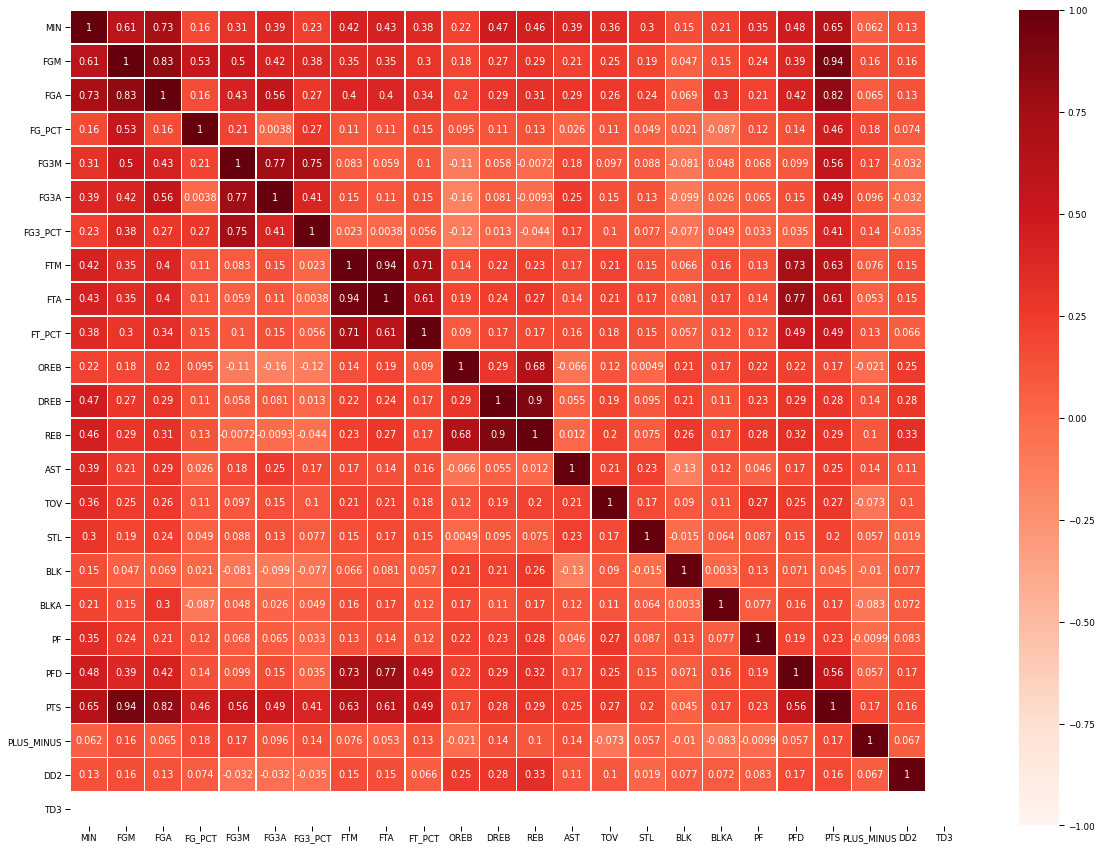

In [27]:
plotSize = (20,15)
# import seaborn as sns
plt.figure(figsize=plotSize)
sns.set_context("paper", font_scale=1)

# sns.heatmap(df.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
print("")
print("Pre Season")
sns.heatmap(df_X_PreSeason.corr(), annot=True, cmap='Reds',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_PreSeason)



Regular Season


<AxesSubplot:>

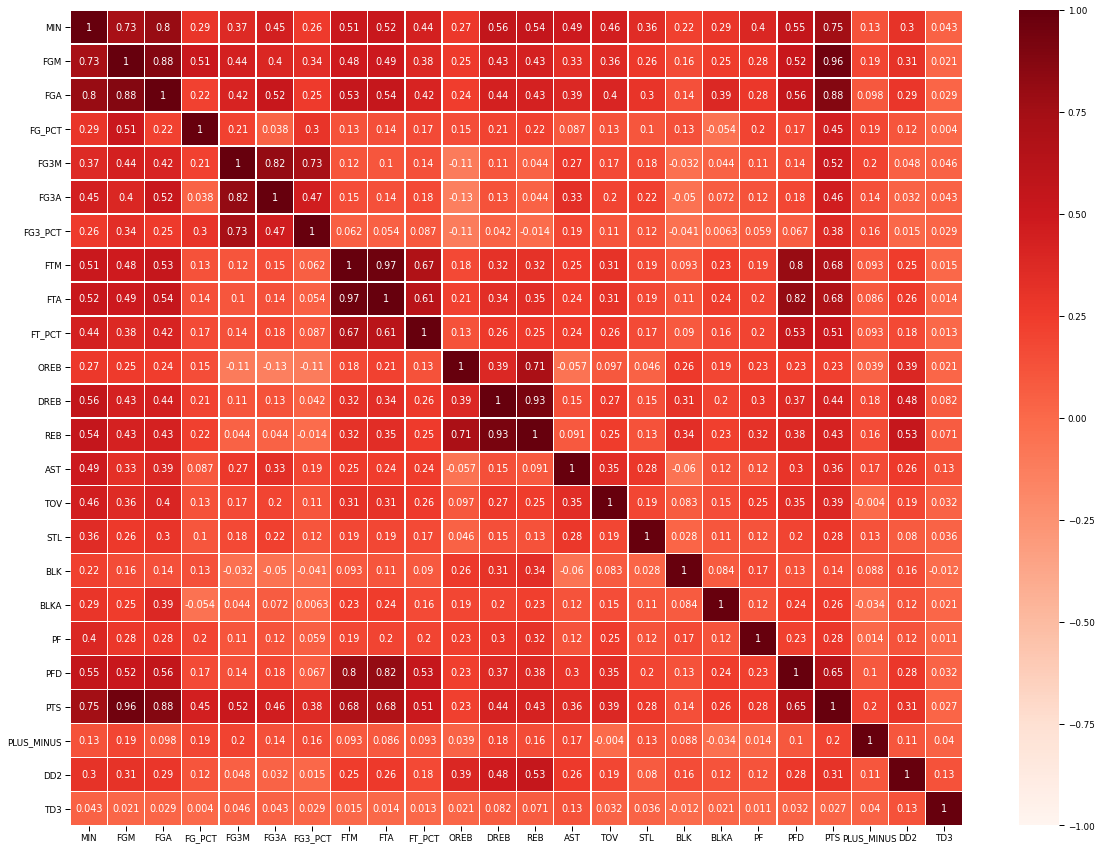

In [28]:
plt.figure(figsize=plotSize)
sns.set_context("paper", font_scale=1)
print("")
print("Regular Season")
sns.heatmap(df_X_RegularSeason.corr(), annot=True, cmap='Reds',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_RegularSeason)



Playoffs


<AxesSubplot:>

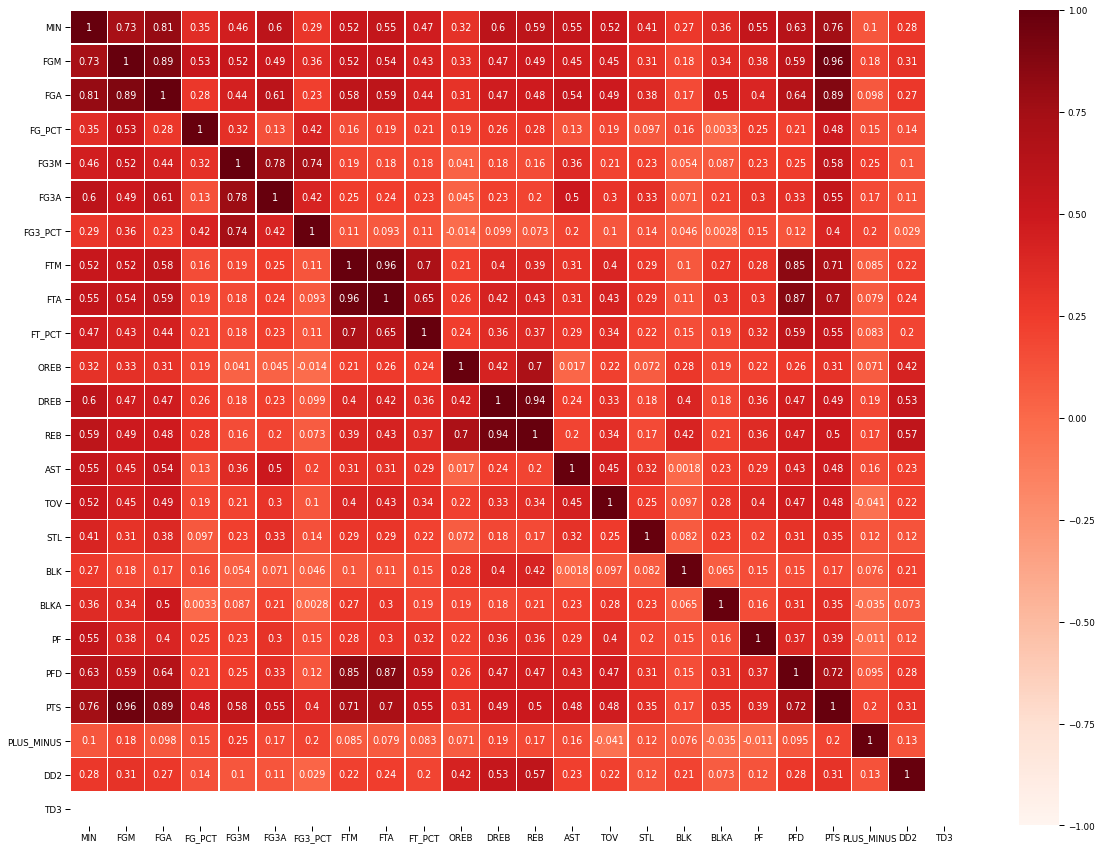

In [29]:
plt.figure(figsize=plotSize)
sns.set_context("paper", font_scale=1)
print("")
print("Playoffs")
sns.heatmap(df_X_Playoffs.corr(), annot=True, cmap='Reds',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_Playoffs)

## Section 5.2: Remove additional unwanted fields based on Heat Map / Correlation Matrix

### Note: Adjust features to remove after analyzing the matrices

In [30]:
## Analysis of heat maps
### Removed anything over 0.8
#### PTS, FGA, FG3M, FTM, PFD, REB


### 2005-2020 TOR

### Preseason
#### FGM or PTS
#### FGA vs PTS
#### FGM or FGA
#### FTM vs FTA
#### PFD vs FTM FTA
#### REB vs DREB

### Reg Season
#### FGM vs PTS
#### FGA vs PTS
#### FGM vs FGA
#### FGA vs MIN
#### FG3A vs FG3M
#### FTM vs FTA
#### FTM vs PFD
#### FTA vs PFD
#### REB vs DREB


### Playoffs
#### FGM vs FGA
#### FGM vs PTS
#### FGA vs PTS
#### FGA vs MIN
#### FTA vs FTM
#### FTM vs PFD
#### FTA vs PFD
#### REB vs DREB


In [31]:
# Remove unwanted/useless features. anything over 80% was removed
# unwanted_list_02 = ['PTS', 'FGA', 'FG3M', 'FTM', 'PFD', 'REB']
unwanted_list_02 = ['PTS', 'FGA', 'FG3M', 'FTM', 'PFD', 'REB']

for gameType in gameTypeListed_code:
    if gameType == 0:
        df_X_PreSeason = df_X_PreSeason.drop(unwanted_list_02, axis=1)
    elif gameType == 1:
        df_X_RegularSeason = df_X_RegularSeason.drop(unwanted_list_02, axis=1)
    elif gameType == 2:
        df_X_Playoffs = df_X_Playoffs.drop(unwanted_list_02, axis=1)


# Remaining features and after removal of unwanted features in the dataframes
# VALIDATION CODE 
if debug_active == 'yes':
    display(X_headers_list)
    display(df_X_PreSeason)
    display(df_X_RegularSeason)
    display(df_X_Playoffs)    

['MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type',
 'PIE',
 'PER',
 'SEASON_YEAR_code']

,MIN,FGM,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PLUS_MINUS,DD2,TD3,PIE,PER
26720,28.300000,8,0.571,4,1.000,5,0.40,3,4,1,0,2,0,1,2,17,0,0,22.4138,34.5267
26724,23.166667,2,0.286,2,0.000,2,1.00,0,2,2,0,2,0,0,3,14,0,0,4.5977,9.69496
26745,17.813333,2,0.500,1,1.000,0,0.00,0,2,3,1,1,0,0,3,12,0,0,5.74713,12.75
26757,5.353333,1,0.333,0,0.000,4,0.25,0,0,1,0,0,0,0,1,2,0,0,-2.29885,2.16781
26767,21.650000,6,0.857,0,0.000,2,0.50,1,1,0,1,0,0,1,3,8,0,0,9.77011,20.8546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440430,12.583333,2,0.500,1,0.000,4,0.75,2,3,3,3,2,0,0,3,3,0,0,5.64516,26.6223
440445,26.850000,7,0.438,6,0.333,8,1.00,2,9,4,5,1,1,1,4,-2,1,0,17.3387,30.9606
440457,22.383333,8,0.800,1,1.000,2,0.50,3,2,1,3,0,1,1,2,-10,0,0,12.0968,31.8193
440464,17.966667,4,0.800,0,0.000,5,0.80,2,5,2,0,0,1,0,3,6,0,0,12.5,37.8855


,MIN,FGM,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PLUS_MINUS,DD2,TD3,PIE,PER
24,22.133333,2,0.500,0,0.000,2,1.000,0,3,0,0,2,1,1,5,-14,0,0,6.61765,13.2093
65,5.133333,0,0.000,0,0.000,0,0.000,0,0,0,0,0,0,0,0,-4,0,0,-2.94118,-15.2688
106,17.250000,1,0.250,3,0.333,0,0.000,0,0,1,0,0,0,0,1,-17,0,0,0,2.17971
125,12.000000,1,1.000,0,0.000,0,0.000,0,1,0,0,0,1,0,2,-11,0,0,2.20588,8.78825
131,30.750000,9,0.643,1,0.000,2,0.500,1,2,9,2,2,1,1,0,8,0,0,36.7647,33.2969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463346,25.993333,4,0.400,1,0.000,6,0.833,2,3,0,3,1,0,0,2,6,0,0,5.7971,11.6566
463353,38.138333,11,0.423,5,0.400,11,0.909,6,12,5,4,0,1,4,6,5,1,0,27.5362,31.8472
463359,44.335000,12,0.667,7,0.714,6,0.833,0,5,7,2,2,0,1,0,18,0,0,37.6812,35.7499
463365,28.645000,2,0.286,5,0.200,0,0.000,1,7,2,2,0,0,0,2,2,0,0,5.31401,3.38551


,MIN,FGM,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PLUS_MINUS,DD2,TD3,PIE,PER
83791,3.250000,1,0.500,2,0.500,0,0.000,0,0,0,2,1,0,0,0,2,0,0,1.21951,13.7169
83792,40.000000,4,0.444,1,0.000,6,0.667,0,1,3,2,1,0,0,5,-10,0,0,3.65854,6.84647
83793,44.900000,4,0.800,0,0.000,2,0.500,1,7,0,1,2,1,1,4,2,0,0,14.6341,11.0854
83794,12.000000,0,0.000,0,0.000,0,0.000,1,1,0,0,0,0,0,2,3,0,0,-1.82927,-1.63675
83797,40.433333,6,0.545,2,1.000,4,0.750,0,7,1,1,1,1,1,3,-5,0,0,20.122,16.5399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,25.583333,8,0.571,4,0.500,4,1.000,3,4,3,1,0,1,0,2,17,0,0,16.8582,38.0876
465022,34.416667,4,0.500,5,0.600,1,1.000,2,3,1,1,1,2,0,5,18,0,0,6.89655,15.6518
465035,7.411667,0,0.000,1,0.000,0,0.000,0,0,3,0,1,0,0,1,11,0,0,1.53257,13.7033
465047,38.683333,11,0.733,10,0.800,1,0.000,0,2,11,1,2,1,1,2,14,1,0,28.7356,42.7009


## Section 5.3: Re-check Heat Map / Correlation Matrix

This is only a check but not necessary.


Pre Season


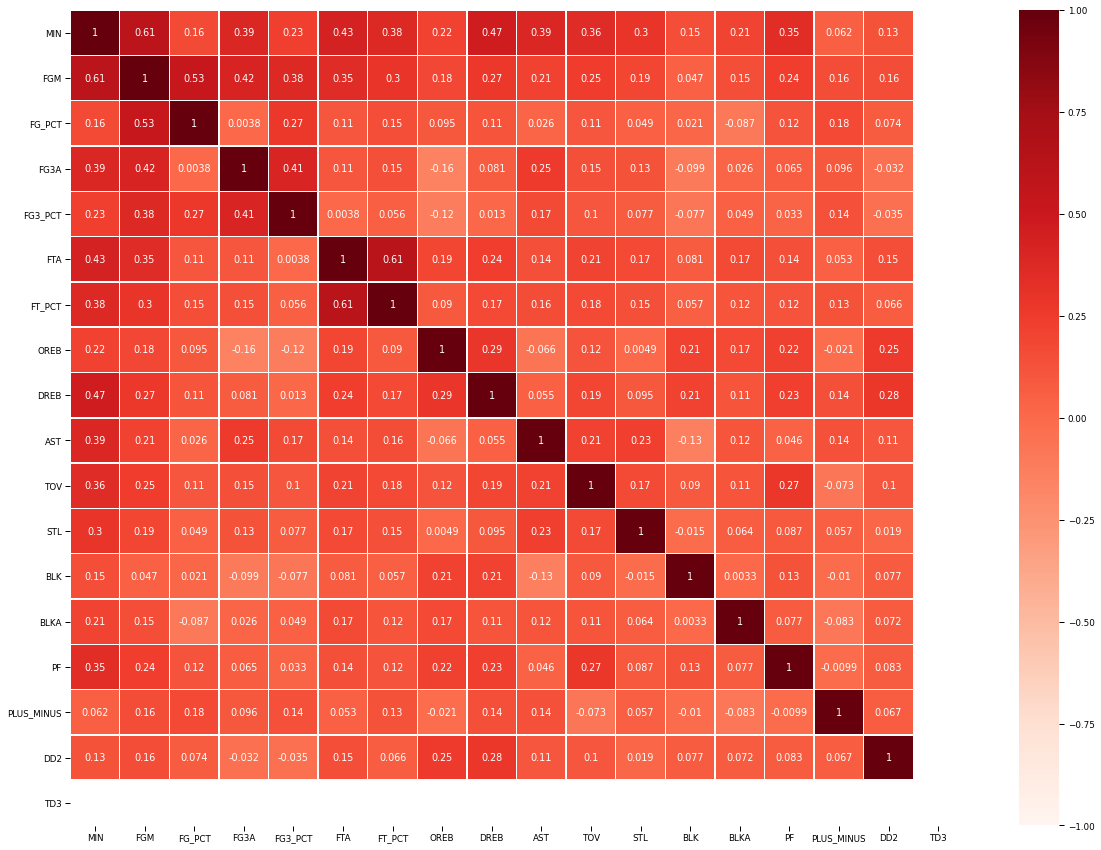

In [32]:
# VALIDATION CODE 
if debug_active == 'yes':
    plt.figure(figsize=plotSize)
    sns.set_context("paper", font_scale=1)
    print("")
    print("Pre Season")
    sns.heatmap(df_X_PreSeason.corr(), annot=True, cmap='Reds',vmin=-1, vmax=1, square=False, linewidths=0.5)
    # display(df_X_PreSeason)



Regular Season


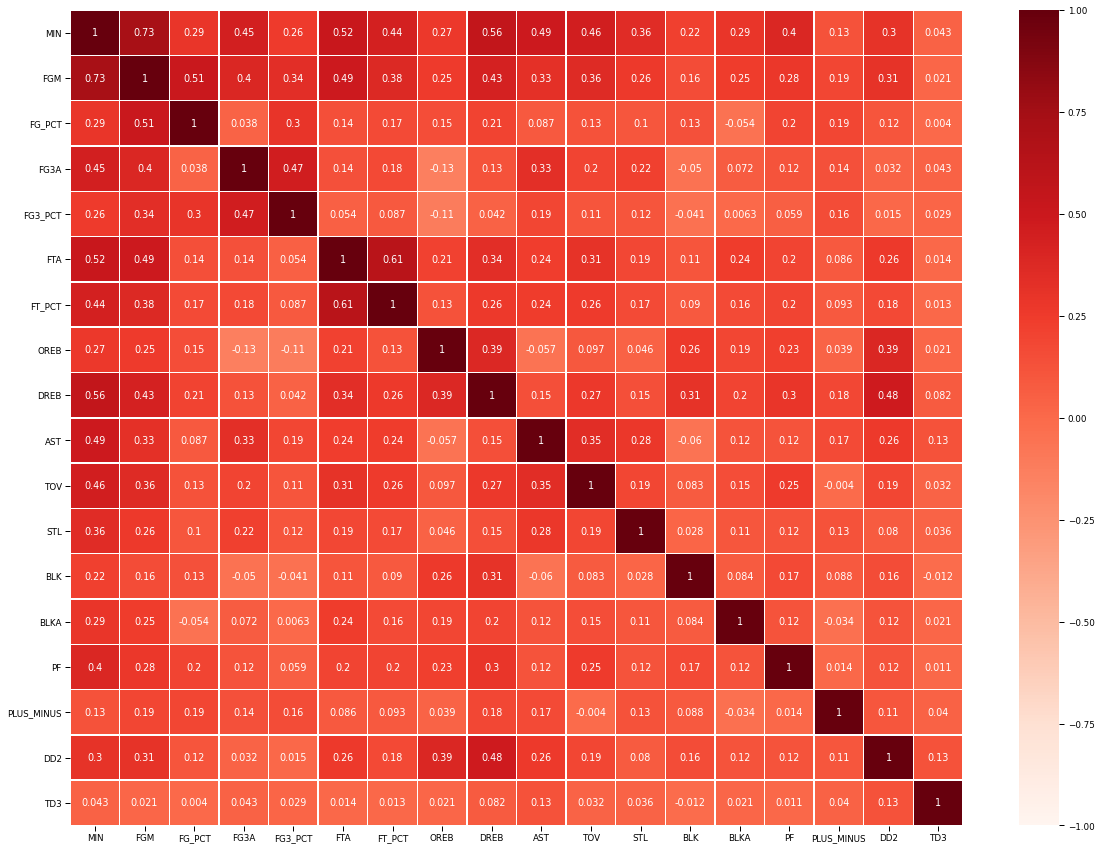

In [33]:
# VALIDATION CODE 
if debug_active == 'yes':
    plt.figure(figsize=plotSize)
    sns.set_context("paper", font_scale=1)
    print("")
    print("Regular Season")
    sns.heatmap(df_X_RegularSeason.corr(), annot=True, cmap='Reds',vmin=-1, vmax=1, square=False, linewidths=0.5)
    # display(df_X_RegularSeason)


Playoffs


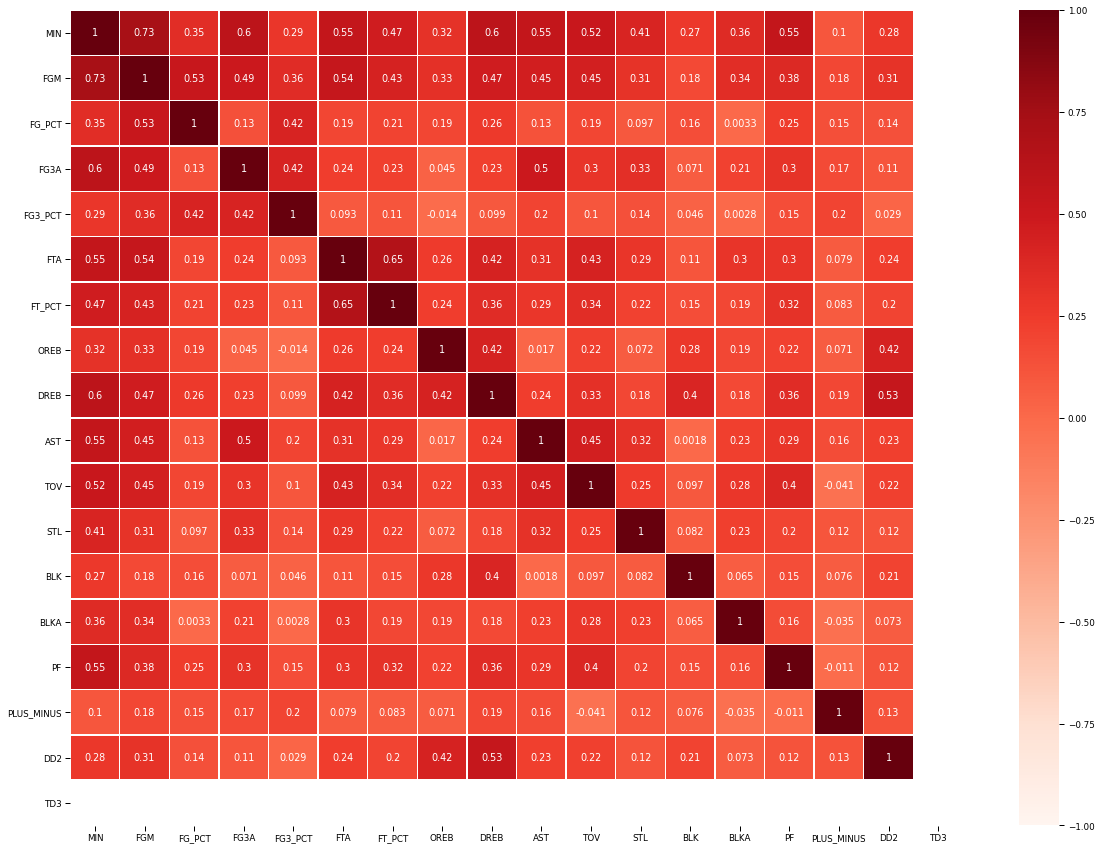

In [34]:
# VALIDATION CODE 
if debug_active == 'yes':
    plt.figure(figsize=plotSize)
    sns.set_context("paper", font_scale=1)
    print("")
    print("Playoffs")
    sns.heatmap(df_X_Playoffs.corr(), annot=True, cmap='Reds',vmin=-1, vmax=1, square=False, linewidths=0.5)
    # display(df_X_Playoffs)

# Section 6: Modeling and Analysis

## Section 6.1: Prepare train and test data

In [35]:
# Select a season 
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
# gameTypeListed_code = [0, 1, 2]

if gameTypeToProcess == 0:
    X = df_X_PreSeason
    Y = df_Y_PreSeason
elif gameTypeToProcess == 1:
    X = df_X_RegularSeason
    Y = df_Y_RegularSeason
elif gameTypeToProcess == 2:
    X = df_X_Playoffs
    Y = df_Y_Playoffs

# Split the code into training and test dataset 0.7/0.3
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = test_size_val, random_state = random_state_val)

selectedSeasonRecordCount = X_train.shape[0] + X_test.shape[0]

# VALIDATION CODE 
if debug_active == 'yes':
    # Validate the split at a high level
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)
    print('Season Type: ', gameTypeToProcess)
    df_Encoded.to_csv('DAT205_Output_All.csv') 
    X_train.to_csv('DAT205_Output_Split_X_train.csv') 
    X_test.to_csv('DAT205_Output_Split_X_test.csv') 
    Y_train.to_csv('DAT205_Output_Split_Y_train.csv') 
    Y_test.to_csv('DAT205_Output_Split_Y_test.csv') 
    display(X_train)
    display(Y_train)


(9360, 20) (9360, 1)
(4012, 20) (4012, 1)
Season Type:  1


,MIN,FGM,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PLUS_MINUS,DD2,TD3,PIE,PER
283719,12.200000,2,0.667,1,1.00,2,0.5,0,2,0,1,2,0,1,2,1,0,0,8.69565,21.32
162591,20.683333,5,0.625,0,0.00,0,0.0,1,2,1,1,0,0,0,2,7,0,0,8.15217,15.8106
97913,20.483333,6,0.600,2,0.50,0,0.0,0,1,2,0,4,0,0,2,-2,0,0,10.9804,32.9906
339662,24.683333,3,0.429,4,0.25,1,1.0,0,3,1,1,1,0,0,3,-1,0,0,5.71429,9.19033
276744,20.600000,4,0.800,2,1.00,2,1.0,1,2,0,1,0,2,0,2,11,0,0,11.5,27.2035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417149,16.750000,4,0.444,5,0.40,0,0.0,0,2,0,0,0,0,1,1,7,0,0,7.05882,15.728
179266,12.520000,1,0.200,0,0.00,0,0.0,3,1,0,0,0,0,2,2,-16,0,0,-1.5625,2.16286
185931,7.666667,2,0.667,0,0.00,2,0.5,3,1,0,0,0,0,1,0,11,0,0,11,38.0427
30039,16.900000,2,0.500,0,0.00,0,0.0,2,4,0,2,0,1,0,4,-7,0,0,2.45902,5.52355


,WL
283719,1
162591,1
97913,1
339662,1
276744,1
...,...
417149,0
179266,1
185931,0
30039,0


In [36]:
# VALIDATION CODE 
if debug_active == 'yes':
    display(X)
    display(Y)

,MIN,FGM,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PLUS_MINUS,DD2,TD3,PIE,PER
24,22.133333,2,0.500,0,0.000,2,1.000,0,3,0,0,2,1,1,5,-14,0,0,6.61765,13.2093
65,5.133333,0,0.000,0,0.000,0,0.000,0,0,0,0,0,0,0,0,-4,0,0,-2.94118,-15.2688
106,17.250000,1,0.250,3,0.333,0,0.000,0,0,1,0,0,0,0,1,-17,0,0,0,2.17971
125,12.000000,1,1.000,0,0.000,0,0.000,0,1,0,0,0,1,0,2,-11,0,0,2.20588,8.78825
131,30.750000,9,0.643,1,0.000,2,0.500,1,2,9,2,2,1,1,0,8,0,0,36.7647,33.2969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463346,25.993333,4,0.400,1,0.000,6,0.833,2,3,0,3,1,0,0,2,6,0,0,5.7971,11.6566
463353,38.138333,11,0.423,5,0.400,11,0.909,6,12,5,4,0,1,4,6,5,1,0,27.5362,31.8472
463359,44.335000,12,0.667,7,0.714,6,0.833,0,5,7,2,2,0,1,0,18,0,0,37.6812,35.7499
463365,28.645000,2,0.286,5,0.200,0,0.000,1,7,2,2,0,0,0,2,2,0,0,5.31401,3.38551


,WL
24,0
65,0
106,0
125,0
131,0
...,...
463346,1
463353,1
463359,1
463365,1


## Section 6.2: Apply Logistic Regression on the split train/test dataset

In [37]:
# np.isnan(df_Encoded.any())
# np.isfinite(df_Encoded.all())

# np.any(np.isnan(df_Encoded))
# np.all(np.isfinite(df_Encoded))

In [38]:
# Notes
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l2',
#                    random_state=0, solver='liblinear', tol=0.0001, verbose=0,
#                    warm_start=False)

# Create the model
LogRegM = LogisticRegression(C=1, solver='liblinear', random_state = random_state_val)

# Train the model
LogRegM.fit(X_train, Y_train.values.ravel())

# Predict using test data
Y_pred = LogRegM.predict(X_test)

df_Y_pred = pd.DataFrame(Y_pred, columns = ['Y_pred'])
df_Y_pred.to_csv('DAT205_Output_Y_pred_LogRegM.csv') 

# Y_pred = pd.DataFrame(Y_pred, columns = ["WL_code"])
# df = pd.DataFrame(data=numpy_data, index=["row1", "row2"], columns=["column1", "column2"])
# VALIDATION CODE 
if debug_active == 'yes':
    display(Y_pred)
    display(df_Y_pred)

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

,Y_pred
0,1
1,1
2,1
3,0
4,0
...,...
4007,1
4008,1
4009,1
4010,0


## Confusion Matrix Analysis Notes
https://www.google.com/search?q=confusion+matrix&rlz=1C1GCEA_enCA849CA849&oq=confusion+&aqs=chrome.1.69i57j0i433l2j0j0i433j0l5.2966j0j7&sourceid=chrome&ie=UTF-8

## Analysis score notes 
https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

### Compute your model’s analysis

In [39]:
accuracy_score_LogRegM = accuracy_score(Y_test, Y_pred)
f1_score_LogRegM = f1_score(Y_test, Y_pred)
recall_score_LogRegM = recall_score(Y_test, Y_pred)
precision_score_LogRegM = precision_score(Y_test, Y_pred)
classification_report_LogRegM = classification_report(Y_test, Y_pred)
confusion_matrix_LogRegM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_LogRegM
sensitivity_LogRegM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_LogRegM = cm[1,1]/(cm[1,0]+cm[1,1])


# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', numFormat.format(accuracy_score_LogRegM))
    print('F1 score:', numFormat.format(f1_score_LogRegM))
    print('Recall:', numFormat.format(recall_score_LogRegM))
    print('Precision:', numFormat.format(precision_score_LogRegM))
    print('Sensitivity : ', numFormat.format(sensitivity_LogRegM))
    print('Specificity : ', numFormat.format(specificity_LogRegM))
    print('\n clasification report:\n', classification_report_LogRegM)
    print('\n confussion matrix:\n',confusion_matrix_LogRegM)

Accuracy: 0.7211
F1 score: 0.7360
Recall: 0.7666
Precision: 0.7078
Sensitivity :  0.6743
Specificity :  0.7666

 clasification report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70      1977
           1       0.71      0.77      0.74      2035

    accuracy                           0.72      4012
   macro avg       0.72      0.72      0.72      4012
weighted avg       0.72      0.72      0.72      4012


 confussion matrix:
 [[1333  644]
 [ 475 1560]]


In [40]:
# Feature Importance
importance = LogRegM.coef_[0]
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_LogRegM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_LogRegM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_LogRegM

## Section 6.3:  Apply Decision Tree Classifier on the split train/test dataset



In [41]:
# Create the model
DTM = DecisionTreeClassifier()

# Train the model
DTM.fit(X_train, Y_train)

# Predict using test data
Y_pred = DTM.predict(X_test)

df_Y_pred = pd.DataFrame(Y_pred, columns = ['Y_pred'])
df_Y_pred.to_csv('DAT205_Output_Y_pred_DTM.csv') 

In [42]:
accuracy_score_DTM = accuracy_score(Y_test, Y_pred)
f1_score_DTM = f1_score(Y_test, Y_pred)
recall_score_DTM = recall_score(Y_test, Y_pred)
precision_score_DTM = precision_score(Y_test, Y_pred)
classification_report_DTM = classification_report(Y_test, Y_pred)
confusion_matrix_DTM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_DTM
sensitivity_DTM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_DTM = cm[1,1]/(cm[1,0]+cm[1,1])

# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', numFormat.format(accuracy_score_DTM))
    print('F1 score:', numFormat.format(f1_score_DTM))
    print('Recall:', numFormat.format(recall_score_DTM))
    print('Precision:', numFormat.format(precision_score_DTM))
    print('Sensitivity : ', numFormat.format(sensitivity_DTM))
    print('Specificity : ', numFormat.format(specificity_DTM))
    print('\n clasification report:\n', classification_report_DTM)
    print('\n confussion matrix:\n',confusion_matrix_DTM)

Accuracy: 0.6800
F1 score: 0.6874
Recall: 0.6939
Precision: 0.6811
Sensitivity :  0.6657
Specificity :  0.6939

 clasification report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67      1977
           1       0.68      0.69      0.69      2035

    accuracy                           0.68      4012
   macro avg       0.68      0.68      0.68      4012
weighted avg       0.68      0.68      0.68      4012


 confussion matrix:
 [[1316  661]
 [ 623 1412]]


In [43]:
# Feature Importance
importance = DTM.feature_importances_
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_DTM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_DTM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_DTM

## Section 6.4: Apply Random Forest Classifier on the split train/test dataset

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
# Create the model
RFM = RandomForestClassifier(max_depth=2, random_state=0)

# Train the model
RFM.fit(X_train, Y_train.values.ravel())

# Predict using test data
Y_pred = RFM.predict(X_test)
df_Y_pred = pd.DataFrame(Y_pred, columns = ['Y_pred'])
df_Y_pred.to_csv('DAT205_Output_Y_pred_RFM.csv') 

In [46]:
accuracy_score_RFM = accuracy_score(Y_test, Y_pred)
f1_score_RFM = f1_score(Y_test, Y_pred)
recall_score_RFM = recall_score(Y_test, Y_pred)
precision_score_RFM = precision_score(Y_test, Y_pred)
classification_report_RFM = classification_report(Y_test, Y_pred)
confusion_matrix_RFM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_RFM
sensitivity_RFM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_RFM = cm[1,1]/(cm[1,0]+cm[1,1])

# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', numFormat.format(accuracy_score_RFM))
    print('F1 score:', numFormat.format(f1_score_RFM))
    print('Recall:', numFormat.format(recall_score_RFM))
    print('Precision:', numFormat.format(precision_score_RFM))
    print('Sensitivity : ', numFormat.format(sensitivity_RFM))
    print('Specificity : ', numFormat.format(specificity_RFM))
    print('\n clasification report:\n', classification_report_RFM)
    print('\n confussion matrix:\n',confusion_matrix_RFM)

Accuracy: 0.7079
F1 score: 0.7288
Recall: 0.7740
Precision: 0.6887
Sensitivity :  0.6399
Specificity :  0.7740

 clasification report:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68      1977
           1       0.69      0.77      0.73      2035

    accuracy                           0.71      4012
   macro avg       0.71      0.71      0.71      4012
weighted avg       0.71      0.71      0.71      4012


 confussion matrix:
 [[1265  712]
 [ 460 1575]]


In [47]:
# Feature Importance
importance = RFM.feature_importances_
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_RFM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_RFM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_RFM

# Section 7: Cross Validation Scores

In [48]:
seed = random_state_val
# seed = 0

loan_models = []
# loan_models.append(('Logistic Regression', LogisticRegression()))
loan_models.append(('Decision Tree', DecisionTreeClassifier()))
# loan_models.append(('KNN', KNeighborsClassifier()))
# loan_models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# loan_models.append(('Gaussian', GaussianNB()))
# loan_models.append(('SVM', SVC()))
loan_models.append(('Random Forest', RandomForestClassifier()))

cross_val_scores = []
model_keys = []

df_cross_val_score = []
df_cross_val_score_headers = [0,1,2,3]
df_cross_val_score = pd.DataFrame (df_cross_val_score, columns = df_cross_val_score_headers)

# VALIDATION CODE 
# if debug_active == 'yes':
#     nullFieldAnalysis(df_cross_val_score)

df_Addscore = []
scoring = 'accuracy'
for model_key, loan_model in loan_models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
    cross_val_score = model_selection.cross_val_score(loan_model, X_train, Y_train.values.ravel(), cv=kfold, scoring=scoring)
    cross_val_scores.append(cross_val_score)
    model_keys.append(model_key)
    msg = "%s: cross val mean -> %f , cross val std -> %f, kfold variance -> %f" % (model_key, cross_val_score.mean(), cross_val_score.std(), cross_val_score.var())
    df_Addscore = pd.Series([model_key, cross_val_score.mean(), cross_val_score.std(), cross_val_score.var()])
    df_cross_val_score = df_cross_val_score.append(df_Addscore, ignore_index=True)
    print(msg)

df_cross_val_score.columns = ['Model_Key','Cross_Value_Score_Mean','Cross_Value_Score_STD','Cross_Value_Score_Var']
# VALIDATION CODE 
if debug_active == 'yes':
    print("")
    print("VALIDATION RESULT")
    display(df_cross_val_score)
    print(model_keys)
    print(cross_val_scores)

Decision Tree: cross val mean -> 0.676496 , cross val std -> 0.010946, kfold variance -> 0.000120
Random Forest: cross val mean -> 0.745726 , cross val std -> 0.011694, kfold variance -> 0.000137

VALIDATION RESULT


,Model_Key,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.676496,0.010946,0.000120
1,Random Forest,0.745726,0.011694,0.000137


['Decision Tree', 'Random Forest']
[array([0.69230769, 0.66773504, 0.67521368, 0.66346154, 0.69444444,
       0.66025641, 0.6784188 , 0.67200855, 0.68589744, 0.67521368]), array([0.74465812, 0.73611111, 0.74358974, 0.75213675, 0.73931624,
       0.74038462, 0.76175214, 0.72222222, 0.76175214, 0.75534188])]


In [49]:
# # WORK IN PROGRESS

# # boxplot algorithm comparison

# # plt.rcParams["figure.figsize"] = (15,10)
# # fig = plt.figure()
# # fig.suptitle('Model Comparison')
# # ax = fig.add_subplot(111)
# # sns.boxplot(x = model_keys, y=cross_val_scores, palette = 'Blues')
# # plt.show()

# # plt.style.use('ggplot')
# plotX = pd.Series(model_keys)
# plotY = pd.Series(cross_val_scores)

# df = pd.DataFrame({"model_keys" : plotX, "cross_val_scores" : plotY})
# # plt.rcParams["figure.figsize"] = (15,10)
# # fig = plt.figure()
# # fig.suptitle('Model Comparison')
# # ax = fig.add_subplot(111)
# sns.set(style="whitegrid")
# sns.boxplot(data=df, palette = 'Blues')



# # plt.style.use('ggplot')
# # dummyData.groupby(['quarter', 'brand'])\
# #       .brand.count().unstack().plot.bar(legend=True)
# plt.show()

In [50]:
# TEST CODE

# print(model_keys)
# print(cross_val_scores)


# print(plotX)
# print(plotY)

# Section 8: Summary Report

In [51]:
# Create summary table of metric analysis
df_Metrics = []

df_Metrics_headers = [0,1,2,3,4,5,6]
df_Metrics = pd.DataFrame (df_Metrics, columns = df_Metrics_headers)


df_AddModel = pd.Series(['Decision Tree',accuracy_score_DTM,f1_score_DTM,recall_score_DTM,precision_score_DTM,sensitivity_DTM,specificity_DTM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['K Nearest Neighbors',accuracy_score_KNNM,f1_score_KNNM,recall_score_KNNM,precision_score_KNNM,sensitivity_KNNM,specificity_KNNM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['Linear Discriminant Analysis',accuracy_score_LDAM,f1_score_LDAM,recall_score_LDAM,precision_score_LDAM,sensitivity_LDAM,specificity_LDAM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['Gaussian Naive Bayes',accuracy_score_GNBM,f1_score_GNBM,recall_score_GNBM,precision_score_GNBM,sensitivity_GNBM,specificity_GNBM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['SVM',accuracy_score_SVMM,f1_score_SVMM,recall_score_SVMM,precision_score_SVMM,sensitivity_SVMM,specificity_SVMM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_AddModel = pd.Series(['Random Forest',accuracy_score_RFM,f1_score_RFM,recall_score_RFM,precision_score_RFM,sensitivity_RFM,specificity_RFM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_AddModel = pd.Series(['Logistic Regression', accuracy_score_LogRegM,f1_score_LogRegM,recall_score_LogRegM,precision_score_LogRegM,sensitivity_LogRegM,specificity_LogRegM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_Metrics.columns = ['Model','Accuracy','F1 score','Recall','Precision','Sensitivity','Specificity']

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Metrics)

# Join dataframes for Metrics and cross_val_scores
df_Summary = pd.concat([df_Metrics,df_cross_val_score], axis=1)
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Summary)

,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity
0,Decision Tree,0.679960,0.687439,0.693857,0.681138,0.665655,0.693857
1,Random Forest,0.707876,0.728829,0.773956,0.688675,0.639858,0.773956
2,Logistic Regression,0.721087,0.736023,0.766585,0.707804,0.674254,0.766585


,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Model_Key,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.679960,0.687439,0.693857,0.681138,0.665655,0.693857,Decision Tree,0.676496,0.010946,0.000120
1,Random Forest,0.707876,0.728829,0.773956,0.688675,0.639858,0.773956,Random Forest,0.745726,0.011694,0.000137
2,Logistic Regression,0.721087,0.736023,0.766585,0.707804,0.674254,0.766585,NaN,NaN,NaN,NaN


In [52]:
# Clean up columns by dropping columns of duplicate data (Model_Key)
df_Summary.drop(['Model_Key'], axis=1, inplace=True)
# df_Summary.drop(columns=['Model_Key'], inplace=True)
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Summary)


,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.679960,0.687439,0.693857,0.681138,0.665655,0.693857,0.676496,0.010946,0.000120
1,Random Forest,0.707876,0.728829,0.773956,0.688675,0.639858,0.773956,0.745726,0.011694,0.000137
2,Logistic Regression,0.721087,0.736023,0.766585,0.707804,0.674254,0.766585,NaN,NaN,NaN


In [53]:
print("================= Results Summary ==================\n")

print("\n==================== Configuration ======================")
print('Filter by Team Selected = ', teamSelected)

print('Total Number of Records (Initial Dataset) = ', totalNumRec)
print('Total Number of Records (Transformed and Filtered Dataset) = ', df_TF.shape[0])
print('Game Type Processed (0 = PreSeason / 1 = RegularSeason / 2 = Playoffs) = ', gameTypeToProcess)
print('Selected Season Records = ', selectedSeasonRecordCount)
print('Train / Test Split = ', test_size_val)
print('Model random_state_val = ', random_state_val)

print("\n==================== Features ======================")
print('----------------- Removed Features -----------------')
display(unwanted_list_01)
print('\n------ Removed attributes - Heat Map / Correlation Matrix ---- ')
display(unwanted_list_02)

print('\n------------------- Applied Features --------------------')
display(X_test.columns.tolist())

print("\n ================= Model Analysis Summary ==================\n")
display(df_Summary)

print('\n\n----------------- Logistic Regression --------------------')
print('Accuracy:', numFormat.format(accuracy_score_LogRegM))
print('F1 score:', numFormat.format(f1_score_LogRegM))
print('Recall:', numFormat.format(recall_score_LogRegM))
print('Precision:', numFormat.format(precision_score_LogRegM))
print('Sensitivity : ', numFormat.format(sensitivity_LogRegM))
print('Specificity : ', numFormat.format(specificity_LogRegM))

print('\n clasification report:\n', classification_report_LogRegM)
print('\n confussion matrix:\n',confusion_matrix_LogRegM)
print("\nFeature Importance")
display(df_feature_importance_LogRegM)

print('\n\n-------------------- Decision Tree -----------------------\n')
print('Accuracy:', numFormat.format(accuracy_score_DTM))
print('F1 score:', numFormat.format(f1_score_DTM))
print('Recall:', numFormat.format(recall_score_DTM))
print('Precision:', numFormat.format(precision_score_DTM))
print('Sensitivity : ', numFormat.format(sensitivity_DTM))
print('Specificity : ', numFormat.format(specificity_DTM))

print('\n clasification report:\n', classification_report_DTM)
print('\n confussion matrix:\n',confusion_matrix_DTM)
print("\nFeature Importance")
display(df_feature_importance_DTM)

# print('\n\n------------- Linear Discriminant Analysis ---------------\n')
# print('\n clasification report:\n', classification_report_LDAM)
# print('\n confussion matrix:\n',confusion_matrix_LDAM)
# print("\nFeature Importance")
# display(df_feature_importance_LDAM)

print('\n\n-------------------- Random Forest -----------------------\n')
print('Accuracy:', numFormat.format(accuracy_score_RFM))
print('F1 score:', numFormat.format(f1_score_RFM))
print('Recall:', numFormat.format(recall_score_RFM))
print('Precision:', numFormat.format(precision_score_RFM))
print('Sensitivity : ', numFormat.format(sensitivity_RFM))
print('Specificity : ', numFormat.format(specificity_RFM))

print('\n clasification report:\n', classification_report_RFM)
print('\n confussion matrix:\n',confusion_matrix_RFM)
print("\nFeature Importance")
display(df_feature_importance_RFM)



================= Results Summary ==================


==================== Configuration ======================
Filter by Team Selected =  TOR
Total Number of Records (Initial Dataset) =  465065
Total Number of Records (Transformed and Filtered Dataset) =  15641
Game Type Processed (0 = PreSeason / 1 = RegularSeason / 2 = Playoffs) =  1
Selected Season Records =  13372
Train / Test Split =  0.3
Model random_state_val =  42

==================== Features ======================
----------------- Removed Features -----------------


['PLAYER_ID',
 'TEAM_ID',
 'PLAYER_NAME',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'UID_STG']


------ Removed attributes - Heat Map / Correlation Matrix ---- 


['PTS', 'FGA', 'FG3M', 'FTM', 'PFD', 'REB']


------------------- Applied Features --------------------


['MIN',
 'FGM',
 'FG_PCT',
 'FG3A',
 'FG3_PCT',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'PIE',
 'PER']


 ================= Model Analysis Summary ==================



,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.679960,0.687439,0.693857,0.681138,0.665655,0.693857,0.676496,0.010946,0.000120
1,Random Forest,0.707876,0.728829,0.773956,0.688675,0.639858,0.773956,0.745726,0.011694,0.000137
2,Logistic Regression,0.721087,0.736023,0.766585,0.707804,0.674254,0.766585,NaN,NaN,NaN




----------------- Logistic Regression --------------------
Accuracy: 0.7211
F1 score: 0.7360
Recall: 0.7666
Precision: 0.7078
Sensitivity :  0.6743
Specificity :  0.7666

 clasification report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70      1977
           1       0.71      0.77      0.74      2035

    accuracy                           0.72      4012
   macro avg       0.72      0.72      0.72      4012
weighted avg       0.72      0.72      0.72      4012


 confussion matrix:
 [[1333  644]
 [ 475 1560]]

Feature Importance


,Feature,Feature Importance
4,FG3_PCT,0.852027
2,FG_PCT,0.705428
17,TD3,0.484009
1,FGM,0.294588
6,FT_PCT,0.276919
8,DREB,0.233480
11,STL,0.214771
12,BLK,0.210807
9,AST,0.175438
15,PLUS_MINUS,0.134254




-------------------- Decision Tree -----------------------

Accuracy: 0.6800
F1 score: 0.6874
Recall: 0.6939
Precision: 0.6811
Sensitivity :  0.6657
Specificity :  0.6939

 clasification report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67      1977
           1       0.68      0.69      0.69      2035

    accuracy                           0.68      4012
   macro avg       0.68      0.68      0.68      4012
weighted avg       0.68      0.68      0.68      4012


 confussion matrix:
 [[1316  661]
 [ 623 1412]]

Feature Importance


,Feature,Feature Importance
15,PLUS_MINUS,0.282007
0,MIN,0.144238
18,PIE,0.136821
19,PER,0.115180
8,DREB,0.033585
2,FG_PCT,0.033550
14,PF,0.032363
9,AST,0.029518
3,FG3A,0.028543
5,FTA,0.022793




-------------------- Random Forest -----------------------

Accuracy: 0.7079
F1 score: 0.7288
Recall: 0.7740
Precision: 0.6887
Sensitivity :  0.6399
Specificity :  0.7740

 clasification report:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68      1977
           1       0.69      0.77      0.73      2035

    accuracy                           0.71      4012
   macro avg       0.71      0.71      0.71      4012
weighted avg       0.71      0.71      0.71      4012


 confussion matrix:
 [[1265  712]
 [ 460 1575]]

Feature Importance


,Feature,Feature Importance
15,PLUS_MINUS,0.409827
18,PIE,0.208351
19,PER,0.101731
4,FG3_PCT,0.084829
2,FG_PCT,0.063292
14,PF,0.033556
8,DREB,0.026872
0,MIN,0.026838
3,FG3A,0.016590
1,FGM,0.008742


In [54]:
time_took = time.time() - start_time
print("")
print("")
print("PROCESSING COMPLETE")
print(f"Total Runtime: {hms_string(time_took)}")
if dataEnhancement_active == 'yes':
    print(f"Add Enhancement Columns Runtime: {hms_string(time_took01)}")
    print(f"Create temp TeamGameStats dataframe Runtime: {hms_string(time_took02)}")
    print(f"Calculate PIE / PER Runtime: {hms_string(time_took03)}")
    # print(f"Calculate PER Runtime: {hms_string(time_took04)}")



PROCESSING COMPLETE
Total Runtime: 2:08:57.65
Add Enhancement Columns Runtime: 0:21:01.36
Create temp TeamGameStats dataframe Runtime: 0:27:25.80
Calculate PIE / PER Runtime: 1:19:45.23


# End of Code